In [3]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')
import pickle

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy import stats
from scipy.spatial import distance
from scipy import ndimage
from scipy.stats import entropy
from random import random
from sklearn.cluster import SpectralBiclustering
import sklearn.metrics as metrics
import itertools

from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.orca.config.use_xvfb = False
plotly.io.orca.config.save()

import importlib

import nltk
nltk.download('punkt')

from collections import Counter

import drawing_utils as drawing 
import block_construction_helpers as bc 

/Users/will/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package punkt to /Users/will/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
experiment_name = 'silhouette'

## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [5]:
iteration_name = 'Exp2Pilot3_all'
num_trials = 24 #for sanity checks

In [6]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

105 participants total


In [7]:
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())
phases = ['pre','repetition 1', 'repetition 2', 'post']

dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

dfic = dfi.copy()
#dfic = dfi[dfi.condition=='repeated']
dfic = dfic[['trialNum','targetName','gameID','condition','blockNum','repetition','phase_extended','flatDiscreteWorld','usableDiscreteWorld','rawF1DiscreteScore']]
dfic['discreteWorld'] = dfic['usableDiscreteWorld']
dfic['flatDiscreteWorldStr'] = dfic['flatDiscreteWorld'].apply(bc.convert_to_str)

#add perfectScore column
dfic = dfic.merge(df[['trialNum','gameID','perfectScore']], how='left', on=['trialNum','gameID'])

max_actions = dfic['blockNum'].max()

In [8]:
targetMaps = {}

with open(os.path.join(csv_dir,'targetMaps.txt')) as json_file:
    targetMaps = json.load(json_file)

def add_ngrams_to_dict(world_states, n, counts):
    n_grams = nltk.ngrams(world_states, n)
    for grams in n_grams:
        counts[' '.join(grams)] = counts.get(' '.join(grams), 0) + 1

# def gini_coefficient(visits):
#     visits = np.array(visits)[:,None]
#     numerator = np.sum(metrics.pairwise_distances(visits))
#     denomenator = 2 * (len(visits)**2) * np.mean(visits)
#     if denomenator == 0:
#         g = 0
#     else:
#         g = numerator/denomenator
#     return g

def get_ngrams(world_states, n):
    return nltk.ngrams(world_states, n)
    
def show_chunk(states, ax, target=None, vmax=None, cmap='Blues', **kwargs):
    start_state_int = np.reshape(list(states[0]),(18,13)).astype(np.int)
    end_state_int = np.reshape(list(states[-1]),(18,13)).astype(np.int)
    chunk = np.bitwise_xor(start_state_int, end_state_int).astype(np.int)
    chunk_plus = end_state_int + chunk
    
    if target:
        chunk_plus = chunk_plus + (1*np.logical_not(targetMaps[target]))*0.2
    
    av_map = np.rot90(chunk_plus)
    
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                  cmap=cmap,
                **kwargs)
    else:
        ax.imshow(av_map,
                  cmap=cmap,
                **kwargs)
        
        
def show_chunk_steps(states, ax, target=None, vmax=None, cmap='Blues', **kwargs):
    
    start_state = np.reshape(list(states[0]),(18,13)).astype(np.int)
    end_state = np.reshape(list(states[-1]),(18,13)).astype(np.int)
    chunk = np.bitwise_xor(start_state, end_state).astype(np.float)
    
    chunk_plus = end_state.astype(np.float) + chunk*0.5
    
#      if target:
#         chunk_plus = chunk_plus - (1*np.logical_not(targetMaps[target]))*0.4
    
    if target:
        world_map = (1*np.logical_not(targetMaps[target]))*0.2
        chunk_plus += world_map
    
    
    for s in states[:-1]:
        chunk_plus -= np.reshape(list(s),(18,13)).astype(np.float)*0.2
    
    av_map = np.rot90(chunk_plus)
    
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                  cmap=cmap,
                **kwargs)
    else:
        ax.imshow(av_map,
                  cmap=cmap,
                **kwargs)

In [9]:
def add_chunk_info(df):
    new_df = df.copy()
    new_df['height'] = new_df.apply(lambda row: bc.chunk_height(row.chunk), axis=1)
    new_df['area'] = new_df.apply(lambda row: bc.chunk_area(row.chunk), axis=1)
    return new_df

### Identify popular chunks in reconstructions, using world-deltas, and various numbers of actions

In [10]:
def find_popular_chunks(data, window_sizes = range(3,8), n_chunks=10):
    
    chunk_data = {}

    # make a dataframe with a group for each reconstruction
    df_target_grouped = data.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

    for chunk_size in window_sizes:

        # Calculate the ngrams of a particular length for each reconstruction
        df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()
        
        chunk_data[chunk_size] = {}
        
        for t in targets:
            
            chunk_data[chunk_size][t] = {}
            chunk_data[chunk_size][t]['ngram_list'] = {}
            chunk_data[chunk_size][t]['diff'] = {}
            chunk_data[chunk_size][t]['diff_counts'] = {}
            chunk_data[chunk_size][t]['top_k_diff'] = {}

            
            # for each target, put the ngrams from all reconstructions into list
            chunk_data[chunk_size][t]['ngram_list'] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
            chunk_data[chunk_size][t]['diff'] = ["".join([str(a) for a in 
                          list((np.array(list(ngram[-1])).astype(np.int) - 
                             np.array(list(ngram[0])).astype(np.int)))]) for ngram in chunk_data[chunk_size][t]['ngram_list']]
            chunk_data[chunk_size][t]['diff_counts'] = Counter(chunk_data[chunk_size][t]['diff']) # count occurrences of each ngram across ppts
            chunk_data[chunk_size][t]['top_k_diff'] =  chunk_data[chunk_size][t]['diff_counts'].most_common(n_chunks)

    return chunk_data
    

#### Find top 10 popular procedural chunks- same shape across a fixed number of actions (window)

In [11]:
# set vars for analysis
n_top_chunks = 12
window_sizes = range(2,7)

In [12]:
# find n_top_chunks most popular chunks for window sizes (i.e. num actions) in all reconstructions
top_chunks_all = find_popular_chunks(dfic, 
                                     window_sizes = window_sizes,
                                     n_chunks=n_top_chunks)

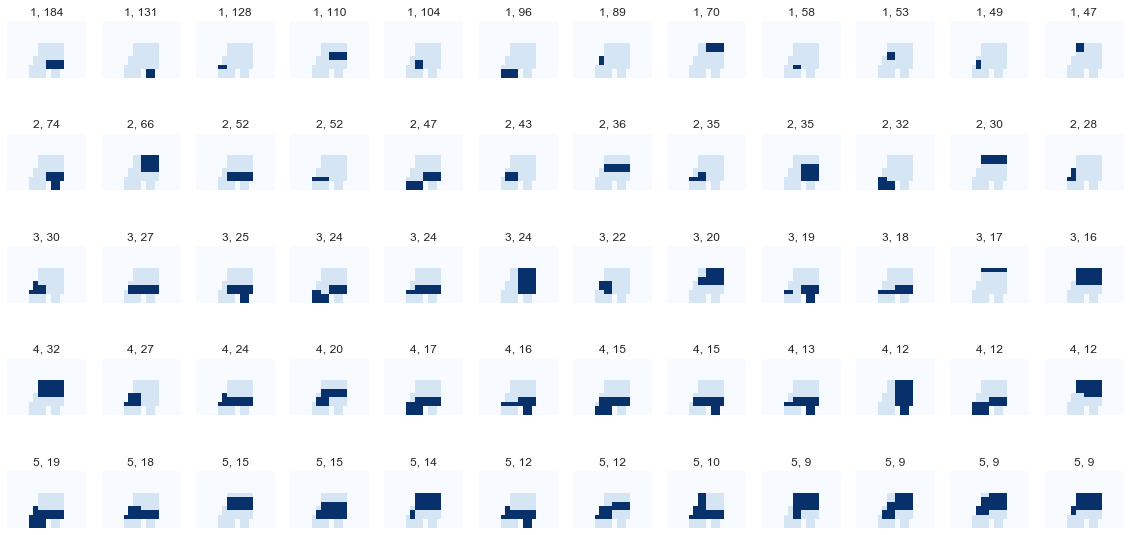

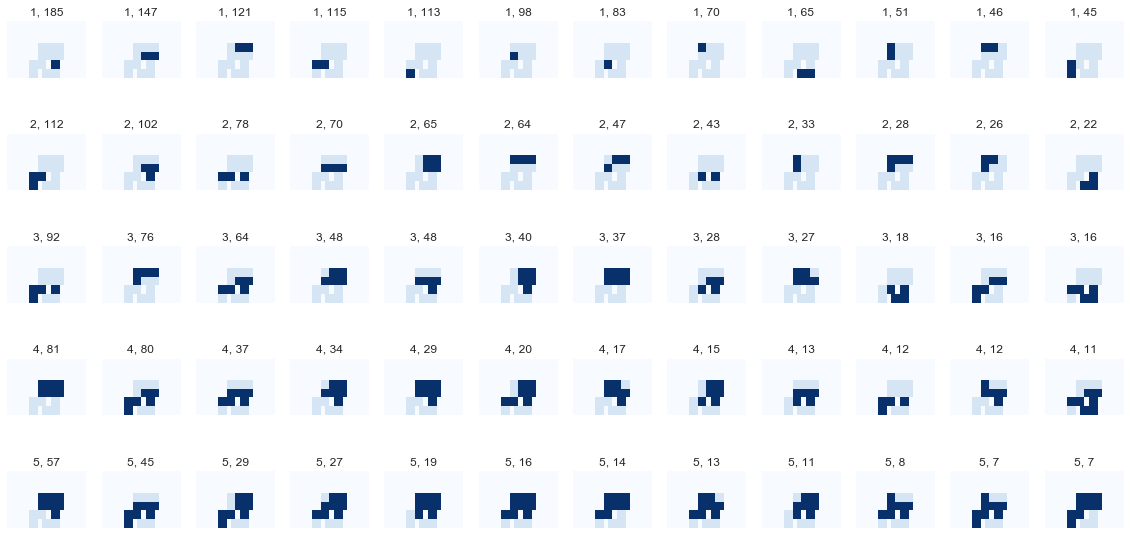

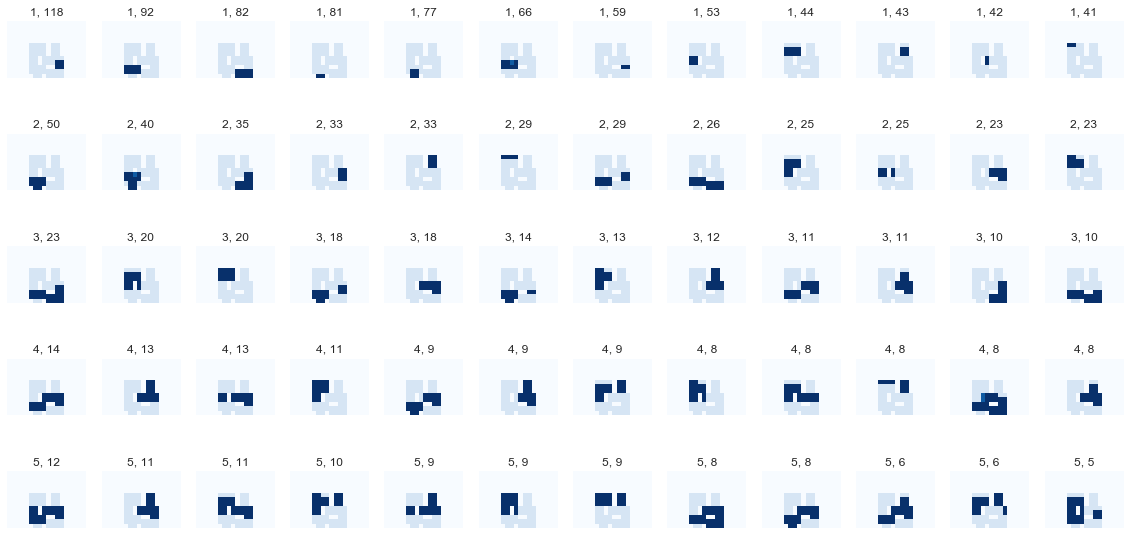

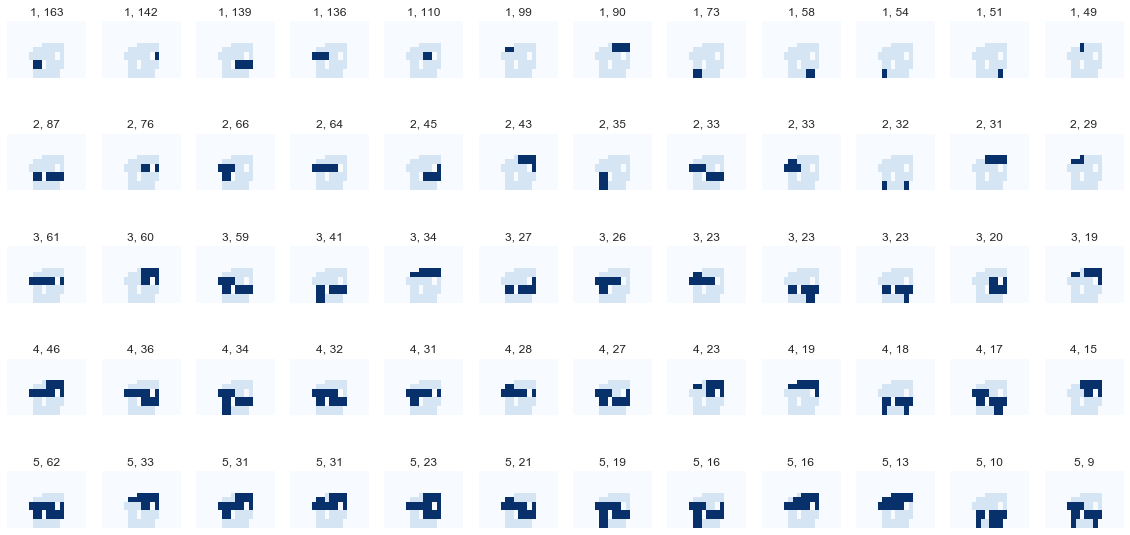

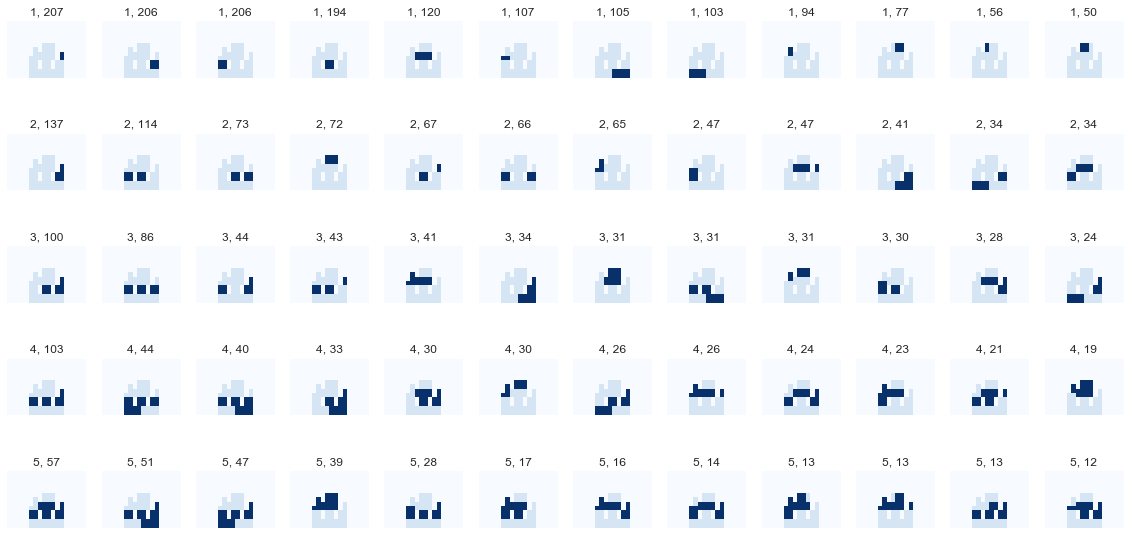

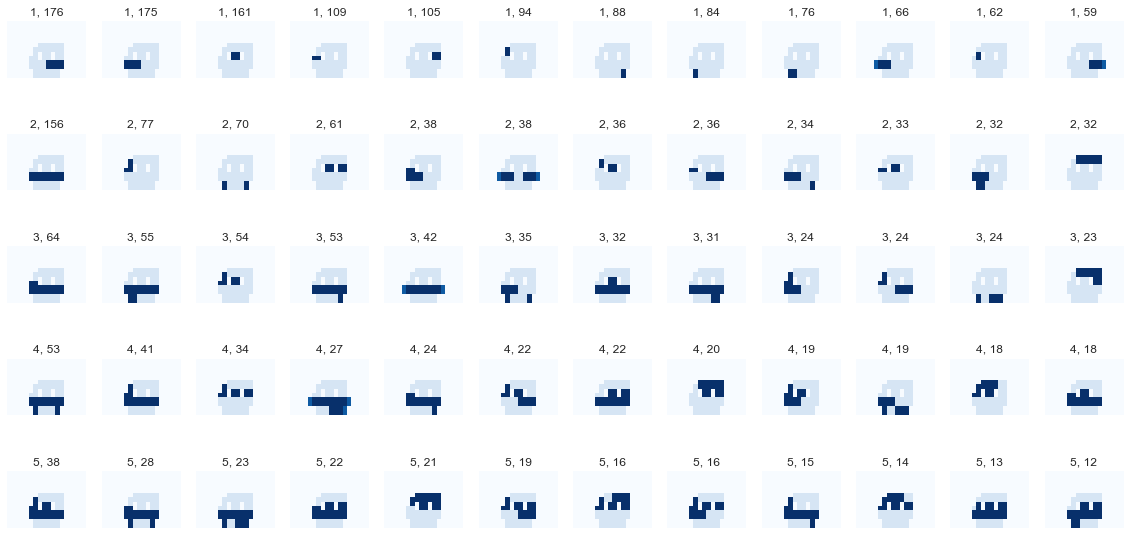

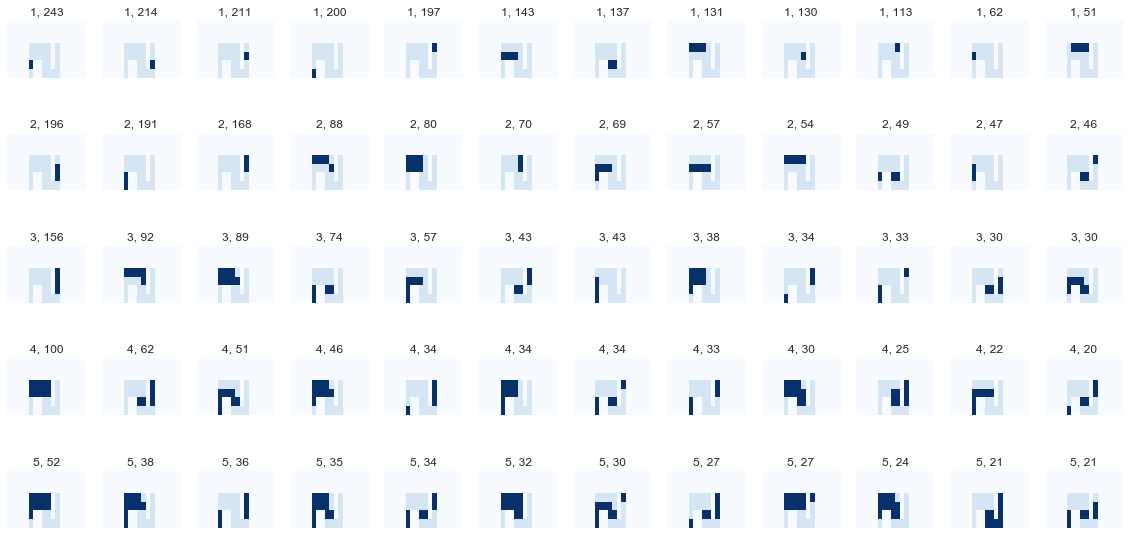

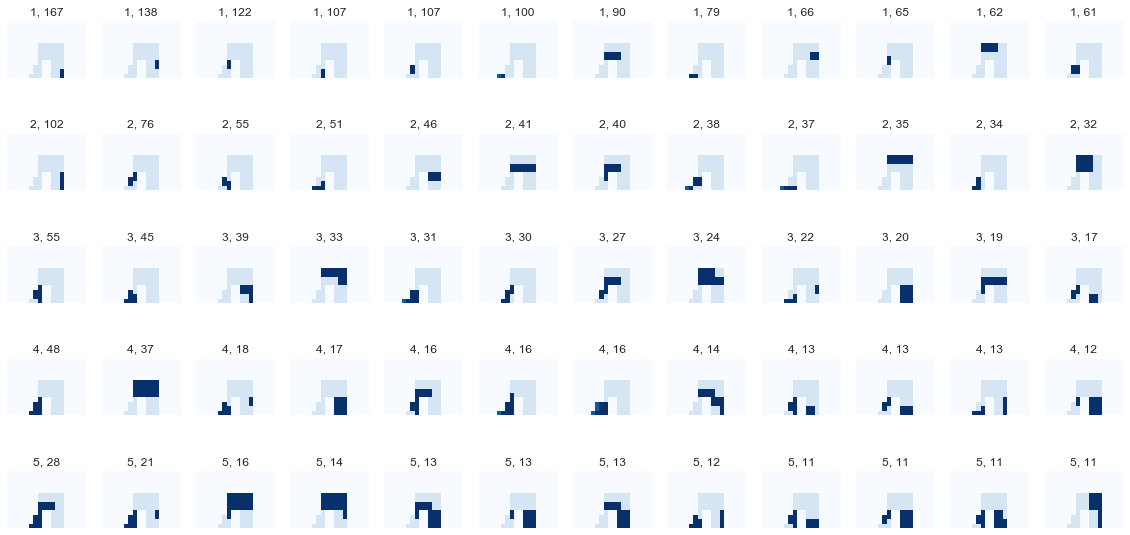

In [45]:
# visualize most popular chunks
# for each ngram, draw the sequence of world states in one image (minus the rest of the image)

for t in targets:

#     print('chunk size: ', chunk_size)
    fig, axs = plt.subplots(len(window_sizes), n_top_chunks, figsize=(20,2*len(window_sizes))) # new figure for each target

    for csi, chunk_size in enumerate(window_sizes):
        for j in range(0,n_top_chunks):
            states = [top_chunks_all[chunk_size][t]['top_k_diff'][j][0]]

            axs[csi,j].axis('off')
            axs[csi,j].set_title(str(chunk_size - 1) + ', ' + str(top_chunks_all[chunk_size][t]['top_k_diff'][j][1]))

            show_chunk(states, axs[csi,j], target=t)


### See where chunks appear most frequently

#### Compute all chunks of all lengths in all reconstructions, so we can check each reconstruction for the presence of a given chunk

In [13]:
# find all chunks for all structures (so later we can search for the structures that involve this chunk)

def compute_all_chunks(window_sizes):

    df_target_grouped = dfic.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

    df_chunks = df.copy()

    for chunk_size in window_sizes:

        # for each reconstruction, get a list of ngrams of that length
        df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

        # find the chunks (world deltas) from those ngrams   
        df_ngrams['world_diff'] = df_ngrams['flatDiscreteWorldStr'].apply(lambda ngrams:
                                         ["".join([str(int(a)) for a in 
                                          list(
                                              np.logical_xor(np.array(list(ngram[-1])).astype(np.bool), 
                                              np.array(list(ngram[0])).astype(np.bool))
                                              )])
                                         for ngram in ngrams])

        df_ngrams = df_ngrams.rename(columns={"flatDiscreteWorldStr": str(chunk_size)+'_grams',
                                              "world_diff": str(chunk_size)+'_chunks'})

        df_chunks = df_chunks.merge(df_ngrams, how='left', on=['gameID','targetName','phase_extended'])
        
    return df_chunks

### leave one out analysis

In [51]:
# set vars for analysis
n_top_chunks = 12 # n most popular chunks
window_sizes = range(2,7) # how many actions are we considering? Window-size of 3 means 2 actions

In [52]:
df_chunks = compute_all_chunks(window_sizes)

In [47]:
# leave-one-out analysis. We are doing this to:
# - see whether people use more procedural chunks/options in their final attempt than in their first
# - identify the most common chunks (common to most sets)

if False:

    df_chunk_use = pd.DataFrame()

    for ppt_i, left_out_ppt in enumerate(ppts):
        print('leaving out ppt ' + str(ppt_i) + ' of ' + str(len(ppts)))
        # filter out one ppt
        df_without_ppt = dfic[dfic.gameID!=left_out_ppt]

        # get popular chunks 
        top_chunks = find_popular_chunks(df_without_ppt,
                                             window_sizes = window_sizes,
                                             n_chunks = n_top_chunks)

        # find statistics for these chunks in the left-out participant 
        for chunk_window in window_sizes:
            for target in targets:
                for rank in range(n_top_chunks):

                    # what now? Find how many are present at the start and how many at the end?

                    # For each chunk, record whether or not it was built by this participant
                    for phase in ['pre','post']:

                        chunk_item = list(top_chunks[chunk_window][target]['top_k_diff'])[rank]
                        chunk = chunk_item[0]

                        n_phase_recons = df_chunks[(df_chunks.phase_extended==phase) & (df_chunks.targetName==target)].shape[0]

                        # check if reconstruction does contain this chunk
                        # search for chunk in the same chunk window (avoid this if we want it to be more option-like)
                        subset_with_chunk = df_chunks[
                                                (df_chunks.gameID==left_out_ppt) &
                                                (df_chunks.targetName == target) & 
                                                (df_chunks.phase_extended == phase) &
                                                (df_chunks[str(chunk_window)+'_chunks'].apply(lambda chunks: chunk in chunks))]

                        if(len(subset_with_chunk)>1):
                            print(subset_with_chunk)

                        assert(len(subset_with_chunk)<=1)

                        df_chunk_use = df_chunk_use.append(
                            {
                                'targetName': target,
                                'chunk_window': chunk_window,
                                'rank': rank,
                                'chunk': chunk,
                                'n_builds_in_training_set': chunk_item[1],
                                'built_by_ppt': len(subset_with_chunk) > 0,
                                'n_phase_recons': n_phase_recons,
    #                             'prop_containing_chunk': (len(subset_with_chunk) > 0) / n_phase_recons,
                                'phase': phase,
                                'chunk_source': 'both_phases' + '_without_' + left_out_ppt

                            },
                            ignore_index=True)

    df_chunk_use_separate_phases['gameID'] = df_chunk_use_separate_phases.chunk_source.apply(lambda x: x.split('_')[2])
    df_chunk_use = add_chunk_info(df_chunk_use)

### Find popular chunks in separate phases, then search for them in the same phase

In [46]:
# separate phases!

# leave-one-out analysis. We are doing this to:
# - see whether people use more procedural chunks/options in their final attempt than in their first
# - identify the most common chunks (common to most sets)

if False:

    df_chunk_use_separate_phases = pd.DataFrame()

    for ppt_i, left_out_ppt in enumerate(ppts):
        print('leaving out ppt ' + str(ppt_i) + ' of ' + str(len(ppts)))

        # find statistics for these chunks in the left-out participant 
        for phase in ['pre','post']:

            # filter out one ppt
            df_phase_without_ppt = dfic[(dfic.gameID!=left_out_ppt) & (dfic.phase_extended==phase)]

            # get popular chunks 
            top_chunks = find_popular_chunks(df_phase_without_ppt,
                                                 window_sizes = window_sizes,
                                                 n_chunks = n_top_chunks)

            for chunk_window in window_sizes:
                for target in targets:
                    for rank in range(n_top_chunks):

                    # what now? Find how many are present at the start and how many at the end?

                    # For each chunk, record whether or not it was built by this participant

                        chunk_item = list(top_chunks[chunk_window][target]['top_k_diff'])[rank]
                        chunk = chunk_item[0]

                        n_phase_recons = df_chunks[(df_chunks.phase_extended==phase) & (df_chunks.targetName==target)].shape[0]

                        # check if reconstruction does contain this chunk
                        # search for chunk in the same chunk window (avoid this if we want it to be more option-like)
                        subset_with_chunk = df_chunks[
                                                (df_chunks.gameID==left_out_ppt) &
                                                (df_chunks.targetName == target) & 
                                                (df_chunks.phase_extended == phase) &
                                                (df_chunks[str(chunk_window)+'_chunks'].apply(lambda chunks: chunk in chunks))]

                        if(len(subset_with_chunk)>1):
                            print(subset_with_chunk)

                        assert(len(subset_with_chunk)<=1)

                        df_chunk_use_separate_phases = df_chunk_use_separate_phases.append(
                            {
                                'targetName': target,
                                'chunk_window': chunk_window,
                                'rank': rank,
                                'chunk': chunk,
                                'n_builds_in_training_set': chunk_item[1],
                                'built_by_ppt': len(subset_with_chunk) > 0,
                                'n_phase_recons': n_phase_recons,
    #                             'prop_containing_chunk': (len(subset_with_chunk) > 0) / n_phase_recons,
                                'phase': phase,
                                'chunk_source': phase + '_without_' + left_out_ppt

                            },
                            ignore_index=True)

    # save left out ppt                    
    df_chunk_use_separate_phases['gameID'] = df_chunk_use_separate_phases.chunk_source.apply(lambda x: x.split('_')[2])
    df_chunk_use_separate_phases = add_chunk_info(df_chunk_use_separate_phases)


In [41]:
# pickle.dump(df_chunk_use_separate_phases_perfect, open("chunk_use_separate_phases_2to6_perfect.p", "wb" ))

In [58]:
# pickle.dump(df_chunk_use_separate_phases, open("df_chunk_use_separate_phases_2to6.p", "wb" ))

In [151]:
# df_chunk_use_separate_phases = pickle.load( open( "df_chunk_use_separate_phases_2to6.p", "rb" ) )

In [66]:
# out_path = os.path.join(csv_dir,'proc_chunk_use_separate_phases_2to6.csv.csv')
# df_chunk_use_separate_phases.to_csv(out_path)

#### Same analysis with perfect reconstructions only

In [48]:
# leave-one-out analysis. We are doing this to:
# - see whether people use more procedural chunks/options in their final attempt than in their first
# - identify the most common chunks (common to most sets)

if False:

    df_chunk_use_separate_phases_perfect = pd.DataFrame()

    for ppt_i, left_out_ppt in enumerate(ppts):
        print('leaving out ppt ' + str(ppt_i) + ' of ' + str(len(ppts)))

        # find statistics for these chunks in the left-out participant 
        for phase in ['pre','post']:

            # filter out one ppt
            df_phase_without_ppt = dfic[(dfic.gameID!=left_out_ppt) & 
                                        (dfic.phase_extended==phase) & 
                                        (dfic.perfectScore)]

            # get popular chunks 
            top_chunks = find_popular_chunks(df_phase_without_ppt,
                                                 window_sizes = window_sizes,
                                                 n_chunks = n_top_chunks)

            for chunk_window in window_sizes:
                for target in targets:
                    for rank in range(n_top_chunks):

                    # what now? Find how many are present at the start and how many at the end?

                    # For each chunk, record whether or not it was built by this participant

                        chunk_item = list(top_chunks[chunk_window][target]['top_k_diff'])[rank]
                        chunk = chunk_item[0]

                        n_phase_recons = df_chunks[(df_chunks.phase_extended==phase) & 
                                                   (df_chunks.targetName==target) &
                                                   (df_chunks.perfectScore)].shape[0]

                        # check if reconstruction does contain this chunk
                        # search for chunk in the same chunk window (avoid this if we want it to be more option-like)
                        subset_with_chunk = df_chunks[
                                                (df_chunks.gameID==left_out_ppt) &
                                                (df_chunks.targetName == target) & 
                                                (df_chunks.phase_extended == phase) &
                                                (df_chunks.perfectScore) &
                                                (df_chunks[str(chunk_window)+'_chunks'].apply(lambda chunks: chunk in chunks))]

                        if(len(subset_with_chunk)>1):
                            print(subset_with_chunk)

                        assert(len(subset_with_chunk)<=1)

                        df_chunk_use_separate_phases_perfect = df_chunk_use_separate_phases_perfect.append(
                            {
                                'targetName': target,
                                'chunk_window': chunk_window,
                                'rank': rank,
                                'chunk': chunk,
                                'n_builds_in_training_set': chunk_item[1],
                                'built_by_ppt': len(subset_with_chunk) > 0,
                                'n_phase_recons': n_phase_recons,
    #                             'prop_containing_chunk': (len(subset_with_chunk) > 0) / n_phase_recons,
                                'phase': phase,
                                'chunk_source': phase + '_without_' + left_out_ppt

                            },
                            ignore_index=True)

    # save left out ppt                    
    df_chunk_use_separate_phases_perfect['gameID'] = df_chunk_use_separate_phases_perfect.chunk_source.apply(lambda x: x.split('_')[2])
    df_chunk_use_separate_phases_perfect = add_chunk_info(df_chunk_use_separate_phases_perfect)


In [49]:
# ALTERNATIVE METHOD FOR PERFECT ONLY- take out ppt before searching if no perfect reconstruction
# NOT USED HERE

# leave-one-out analysis. We are doing this to:
# - see whether people use more procedural chunks/options in their final attempt than in their first
# - identify the most common chunks (common to most sets)

if False:

    df_chunk_use_separate_phases_perfect_only = pd.DataFrame()

    for ppt_i, left_out_ppt in enumerate(ppts):
        print('leaving out ppt ' + str(ppt_i) + ' of ' + str(len(ppts)))

        # find statistics for these chunks in the left-out participant 
        for phase in ['pre','post']:

            # filter out one ppt
            df_phase_without_ppt = dfic[(dfic.gameID!=left_out_ppt) & 
                                        (dfic.phase_extended==phase) & 
                                        (dfic.perfectScore)]

            # get popular chunks 
            top_chunks = find_popular_chunks(df_phase_without_ppt,
                                                 window_sizes = window_sizes,
                                                 n_chunks = n_top_chunks)

            for chunk_window in window_sizes:
                for target in targets:

                    #if left-out reconstruction is perfect
                    if (dfic[(dfic.gameID==left_out_ppt) & 
                         (dfic.phase_extended==phase) & 
                         (dfic.targetName==target)]['perfectScore'].iloc[0]):

                        for rank in range(n_top_chunks):

                        # what now? Find how many are present at the start and how many at the end?

                        # For each chunk, record whether or not it was built by this participant

                            chunk_item = list(top_chunks[chunk_window][target]['top_k_diff'])[rank]
                            chunk = chunk_item[0]

                            n_phase_recons = df_chunks[(df_chunks.phase_extended==phase) & 
                                                       (df_chunks.targetName==target) &
                                                       (df_chunks.perfectScore)].shape[0]

                            # check if reconstruction does contain this chunk
                            # search for chunk in the same chunk window (avoid this if we want it to be more option-like)
                            subset_with_chunk = df_chunks[
                                                    (df_chunks.gameID==left_out_ppt) &
                                                    (df_chunks.targetName == target) & 
                                                    (df_chunks.phase_extended == phase) &
                                                    (df_chunks.perfectScore) &
                                                    (df_chunks[str(chunk_window)+'_chunks'].apply(lambda chunks: chunk in chunks))]

                            if(len(subset_with_chunk)>1):
                                print(subset_with_chunk)

                            assert(len(subset_with_chunk)<=1)

                            df_chunk_use_separate_phases_perfect_only = df_chunk_use_separate_phases_perfect_only.append(
                                {
                                    'targetName': target,
                                    'chunk_window': chunk_window,
                                    'rank': rank,
                                    'chunk': chunk,
                                    'n_builds_in_training_set': chunk_item[1],
                                    'built_by_ppt': len(subset_with_chunk) > 0,
                                    'n_phase_recons': n_phase_recons,
    #                                 'prop_containing_chunk': (len(subset_with_chunk) > 0) / n_phase_recons,
                                    'phase': phase,
                                    'chunk_source': phase + '_without_' + left_out_ppt

                                },
                                ignore_index=True)

    # save left out ppt                    
    df_chunk_use_separate_phases_perfect_only['gameID'] = df_chunk_use_separate_phases_perfect_only.chunk_source.apply(lambda x: x.split('_')[2])
    df_chunk_use_separate_phases_perfect_only = add_chunk_info(df_chunk_use_separate_phases_perfect_only)

# pickle.dump(df_chunk_use_separate_phases_perfect_only, open("proc_chunk_use_separate_phases_2to6_perfect_only.p", "wb" ))

In [152]:
# df_sums_perfect = df_chunk_use_separate_phases_perfect.groupby(['gameID','phase','targetName','chunk_window']).built_by_ppt.sum().reset_index()
# df_sums_perfect

## Load in precomputed dataframes (made with cells above)

In [45]:
df_chunk_use = pickle.load(open("df_chunk_use_2to6.p", "rb" ))

In [26]:
df_chunk_use_separate_phases = pickle.load(open("df_chunk_use_separate_phases_2to6.p", "rb" ))

In [43]:
df_chunk_use_separate_phases_perfect = pickle.load(open("chunk_use_separate_phases_2to6_perfect.p", "rb" ))

In [55]:
df_sums_separate_phases = df_chunk_use_separate_phases.groupby(['gameID','phase','targetName','chunk_window']).built_by_ppt.sum().reset_index()

In [54]:
df_individual_chunk_sums = df_chunk_use_separate_phases.groupby(['gameID','phase','targetName','chunk']).built_by_ppt.sum().reset_index()

In [63]:
# out_path = os.path.join(csv_dir,'summed_proc_chunk_use_separate_phases_2to6.csv')
# df_sums_separate_phases.to_csv(out_path)

### Use of popular procedural chunks, pre to post

Switch in name of dataframe to see patterns for different methods of collecting data

#### Chunks from all reconstructions

<Figure size 720x432 with 0 Axes>

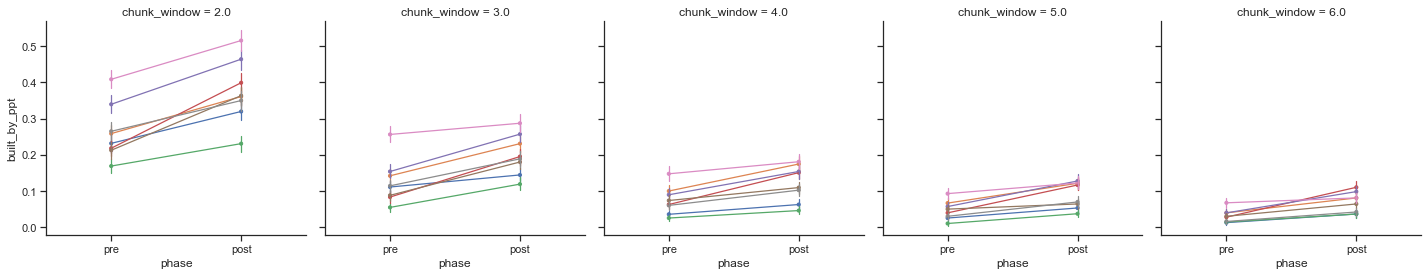

In [51]:
# How often were most popular chunks built by left-out ppt, by phase, by structure?

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_chunk_use_separate_phases, col="chunk_window", height=4, hue='targetName')
g.map(sns.pointplot, "phase", "built_by_ppt", order=['pre','post']);

#### Chunks from perfect reconstructions

<Figure size 720x432 with 0 Axes>

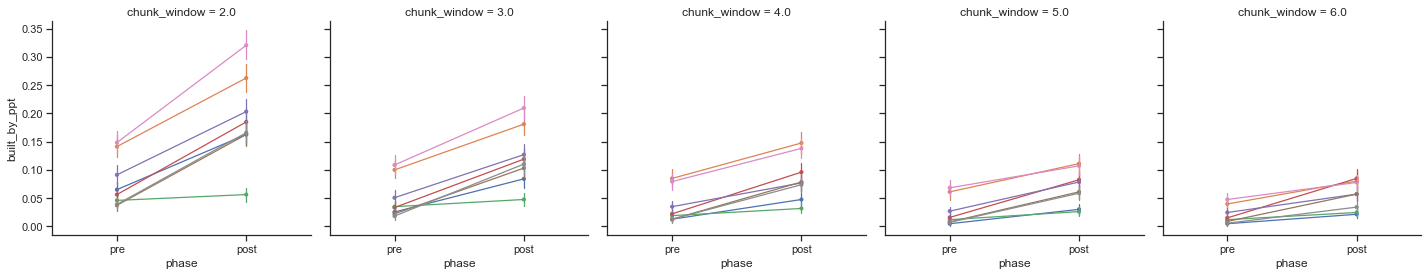

In [84]:
# How often were most popular chunks built by left-out ppt, by phase, by structure?

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_chunk_use_separate_phases_perfect, col="chunk_window", height=4, hue='targetName')
g.map(sns.pointplot, "phase", "built_by_ppt", order=['pre','post']);

#### By individual chunk

<Figure size 720x432 with 0 Axes>

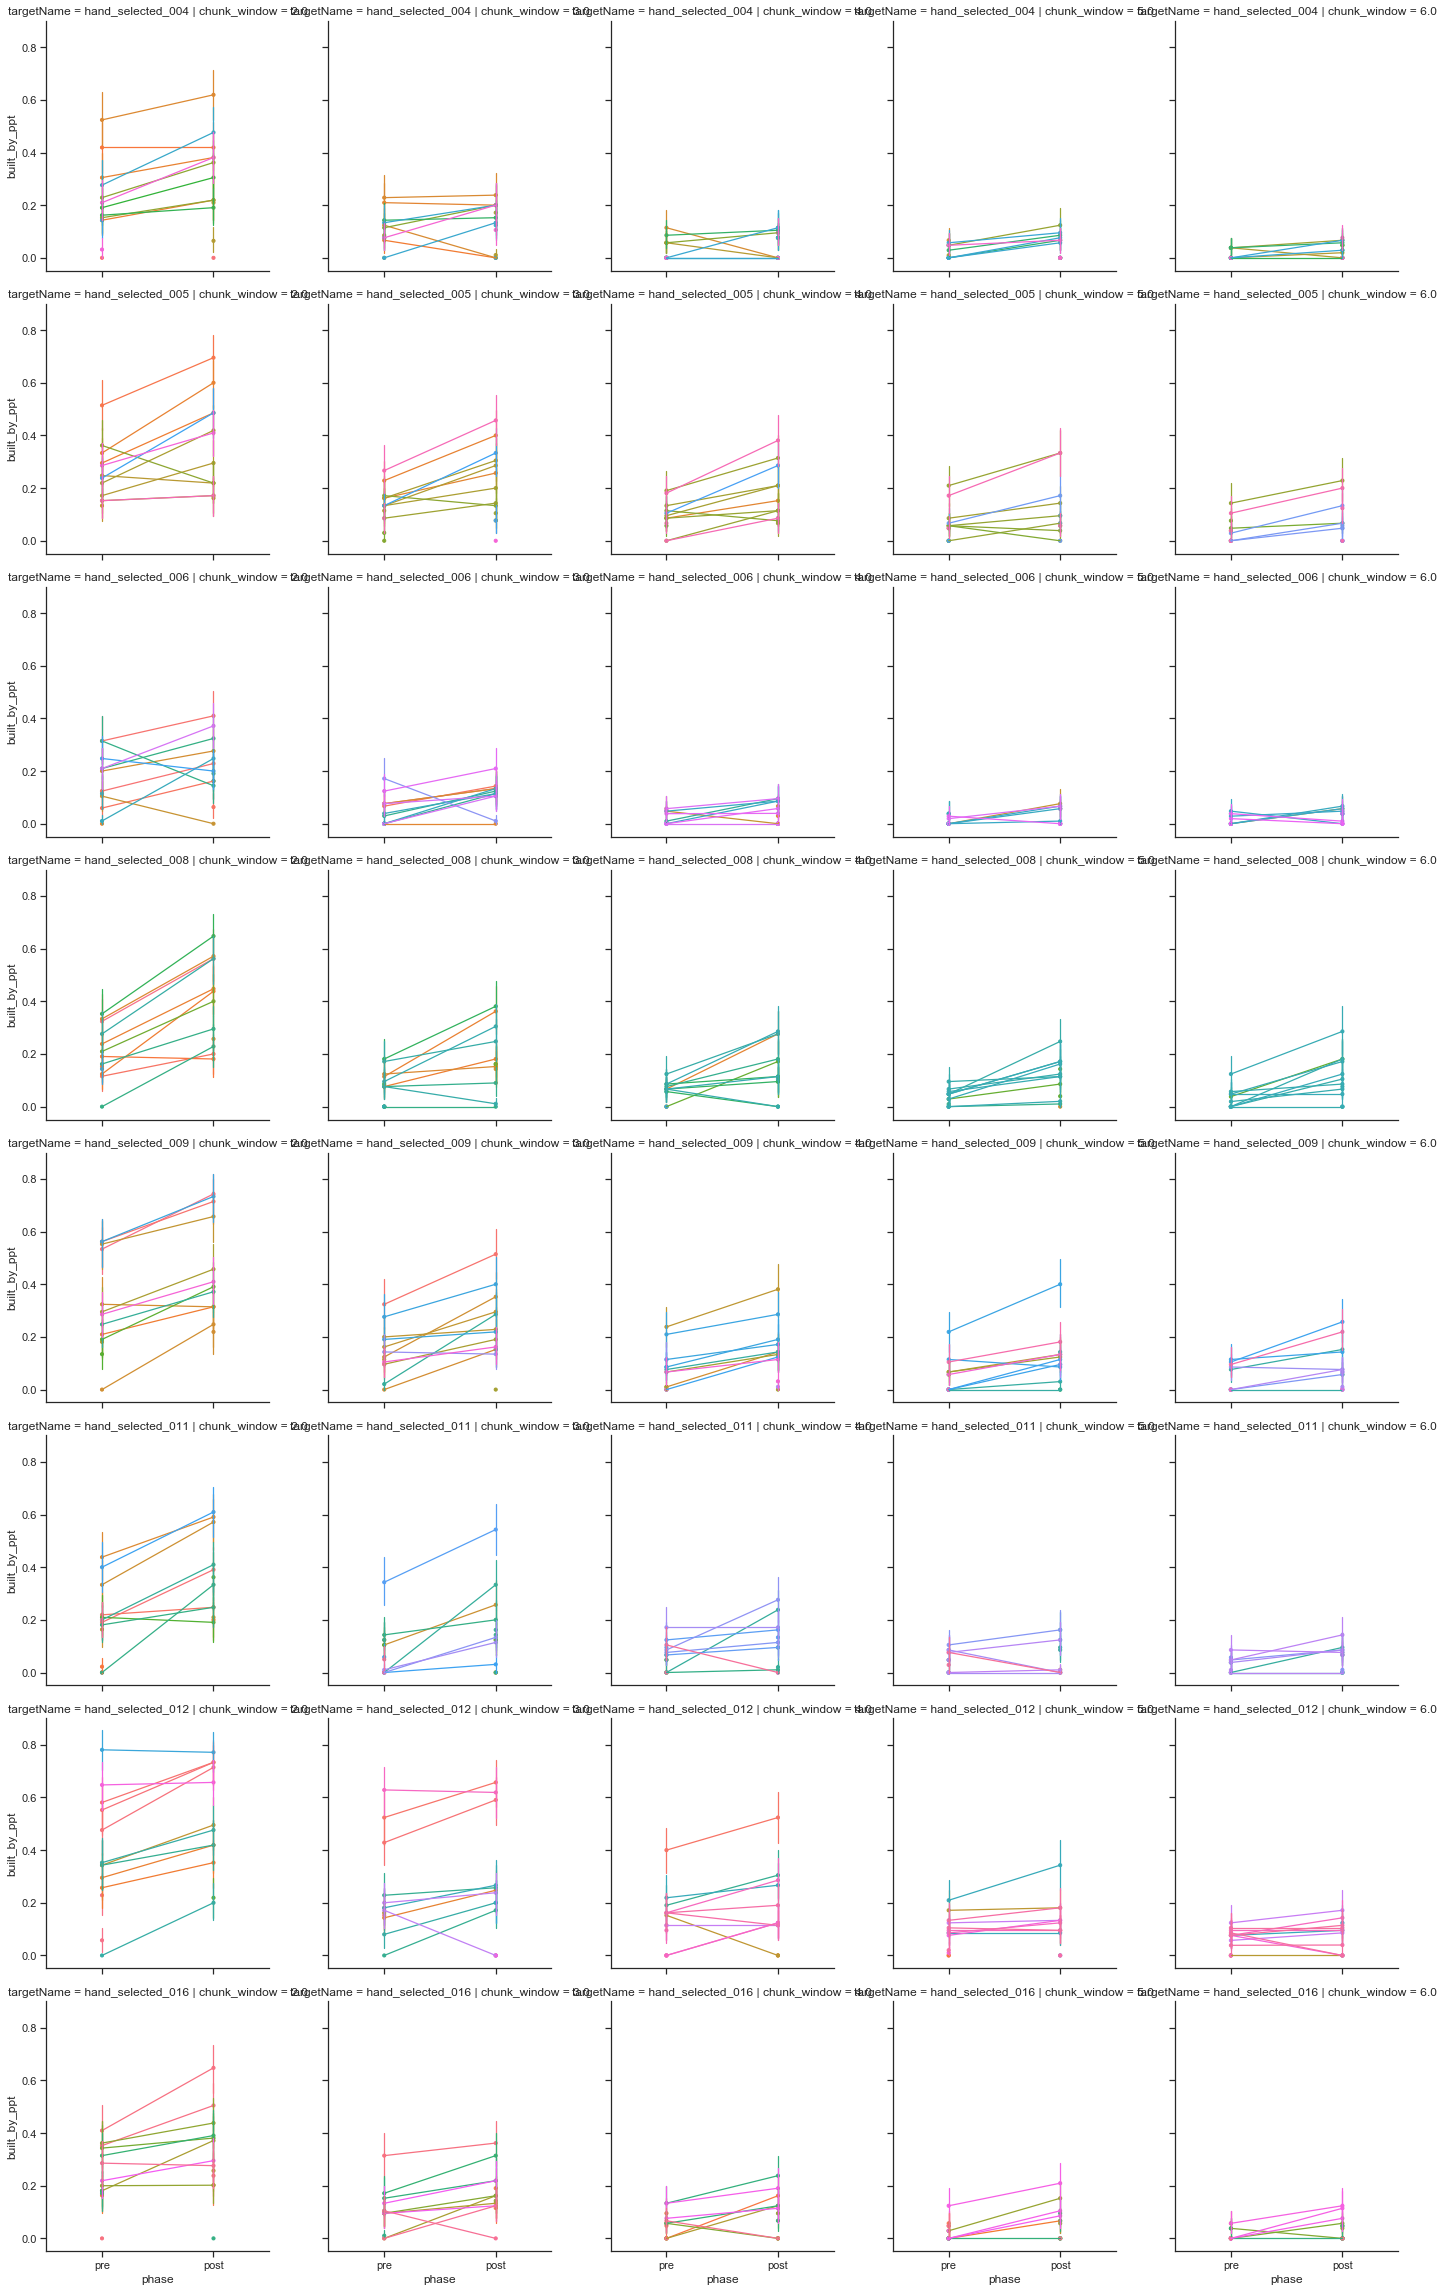

In [52]:
# How often were most popular chunks built by left-out ppt, by phase?
# by individual chunk

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_chunk_use_separate_phases, col="chunk_window", row="targetName", height=4, hue='chunk')
g.map(sns.pointplot, "phase", "built_by_ppt", order=['pre','post']);

## Get top procedural chunks

### Top movers first to final attempt

In [56]:
def get_diff(rows):
    print(rows)
    post = rows[rows.phase=='post']
    pre = rows[rows.phase=='pre']
    assert len(post)<2
    assert len(pre)<2

    if (len(post)==1)&(len(pre)==1):
        return post.built_by_ppt[0] - pre.built_by_ppt[0]
    elif len(post)==1:
        return post.built_by_ppt[0]
    else:
        return -pre.built_by_ppt[0]
        

#### All reconstructions

In [85]:
df_popular_chunks = df_chunk_use_separate_phases.groupby(['chunk','phase','targetName','chunk_window']).\
    agg(built_by_ppt_proportion=('built_by_ppt', np.mean),
        built_by_ppt_total=('built_by_ppt', np.sum),
        height=('height','first'),
        area=('area','first')
       ).reset_index()

In [86]:
#trying to find difference between pre and post here, to identify biggest movers:
df_proc_diff = df_popular_chunks.pivot(index=['targetName','chunk_window','chunk'], columns="phase", values="built_by_ppt_proportion").fillna(0)
df_proc_diff['diff'] = df_proc_diff['post'] - df_proc_diff['pre']
df_proc_diff = df_proc_diff.reset_index()

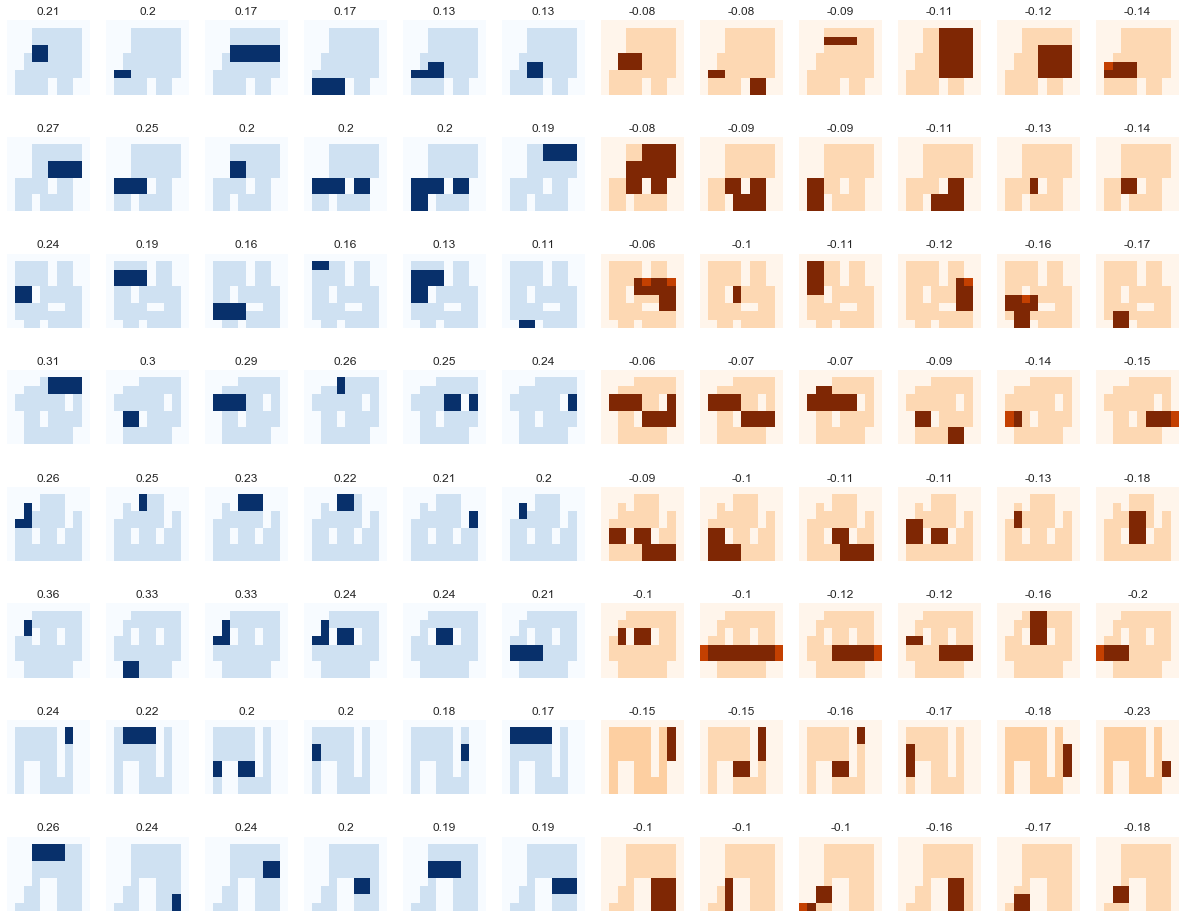

In [95]:
n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(3.5*n_chunks,2.1*len(targets)))

sns.set_context('poster')
# sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff[df_proc_diff.targetName==target].sort_values('diff', ascending=False).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,j].set_title(str(round(greatest_increase.loc[j,'diff'],2)))
        axs[i,j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff[df_proc_diff.targetName==target].sort_values('diff', ascending=True).reset_index()
        axs[i,n_chunks*2-1-j].set_title(str(round(greatest_increase.loc[j,'diff'],2)))
        axs[i,n_chunks*2-1-j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Oranges', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

#### Perfect top chunks, imperfect reconstructions,

In [71]:
df_popular_chunks_perfect = df_chunk_use_separate_phases_perfect.groupby(['chunk','phase','targetName','chunk_window']).\
    agg(built_by_ppt_proportion=('built_by_ppt', np.mean),
        built_by_ppt_total=('built_by_ppt', np.sum),
        height=('height','first'),
        area=('area','first')
       ).reset_index()


In [72]:
#trying to find difference between pre and post here, to identify biggest movers:
df_proc_diff_perfect = df_popular_chunks_perfect.pivot(index=['targetName','chunk_window','chunk'], columns="phase", values="built_by_ppt_proportion").fillna(0)
df_proc_diff_perfect['diff'] = df_proc_diff_perfect['post'] - df_proc_diff_perfect['pre']
df_proc_diff_perfect = df_proc_diff_perfect.reset_index()


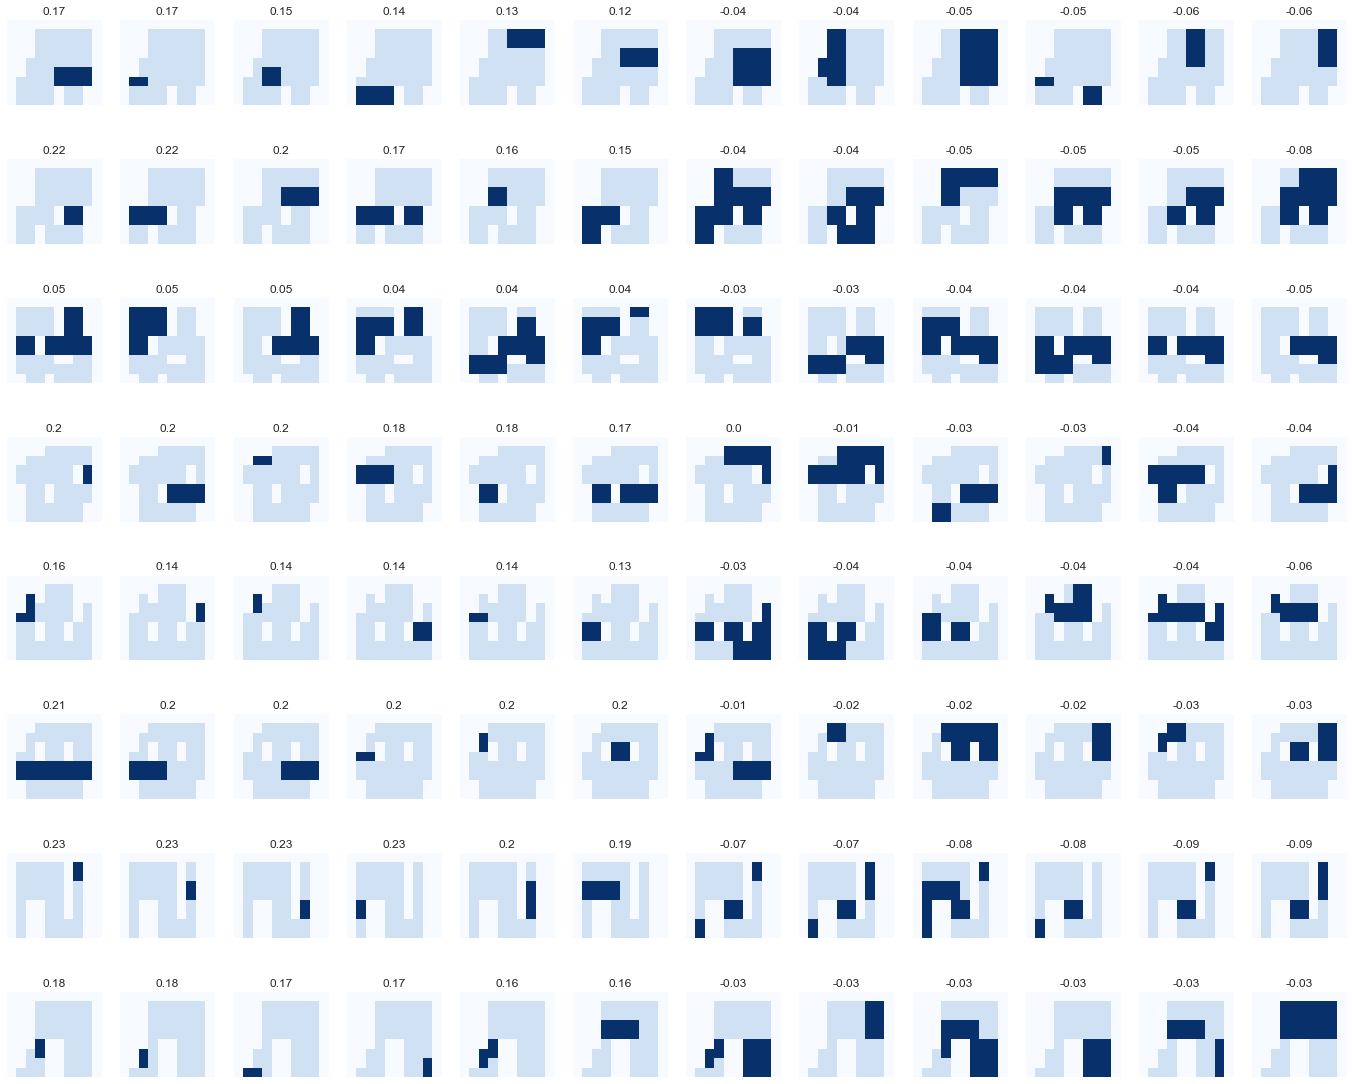

In [73]:
#top movers
n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff_perfect[df_proc_diff_perfect.targetName==target].sort_values('diff', ascending=False).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,j].set_title(str(round(greatest_increase.loc[j,'diff'],2)))
        axs[i,j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff_perfect[df_proc_diff_perfect.targetName==target].sort_values('diff', ascending=True).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,n_chunks*2-1-j].set_title(str(round(greatest_increase.loc[j,'diff'],2)))
        axs[i,n_chunks*2-1-j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Blues', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

####  Perfect top chunks, perfect reconstructions

In [598]:
df_popular_chunks_double_perfect = df_chunk_use_separate_phases_perfect_only.groupby(['chunk','phase','targetName','chunk_window']).\
    agg(built_by_ppt_proportion=('built_by_ppt', np.mean),
        built_by_ppt_total=('built_by_ppt', np.sum),
        height=('height','first'),
        area=('area','first')
       ).reset_index()


In [599]:
#trying to find difference between pre and post here, to identify biggest movers_double_perfect:
df_proc_diff_double_perfect = df_popular_chunks_double_perfect.pivot(index=['targetName','chunk_window','chunk'], columns="phase", values="built_by_ppt_proportion").fillna(0)
df_proc_diff_double_perfect['diff'] = df_proc_diff_double_perfect['post'] - df_proc_diff_double_perfect['pre']
df_proc_diff_double_perfect = df_proc_diff_double_perfect.reset_index()

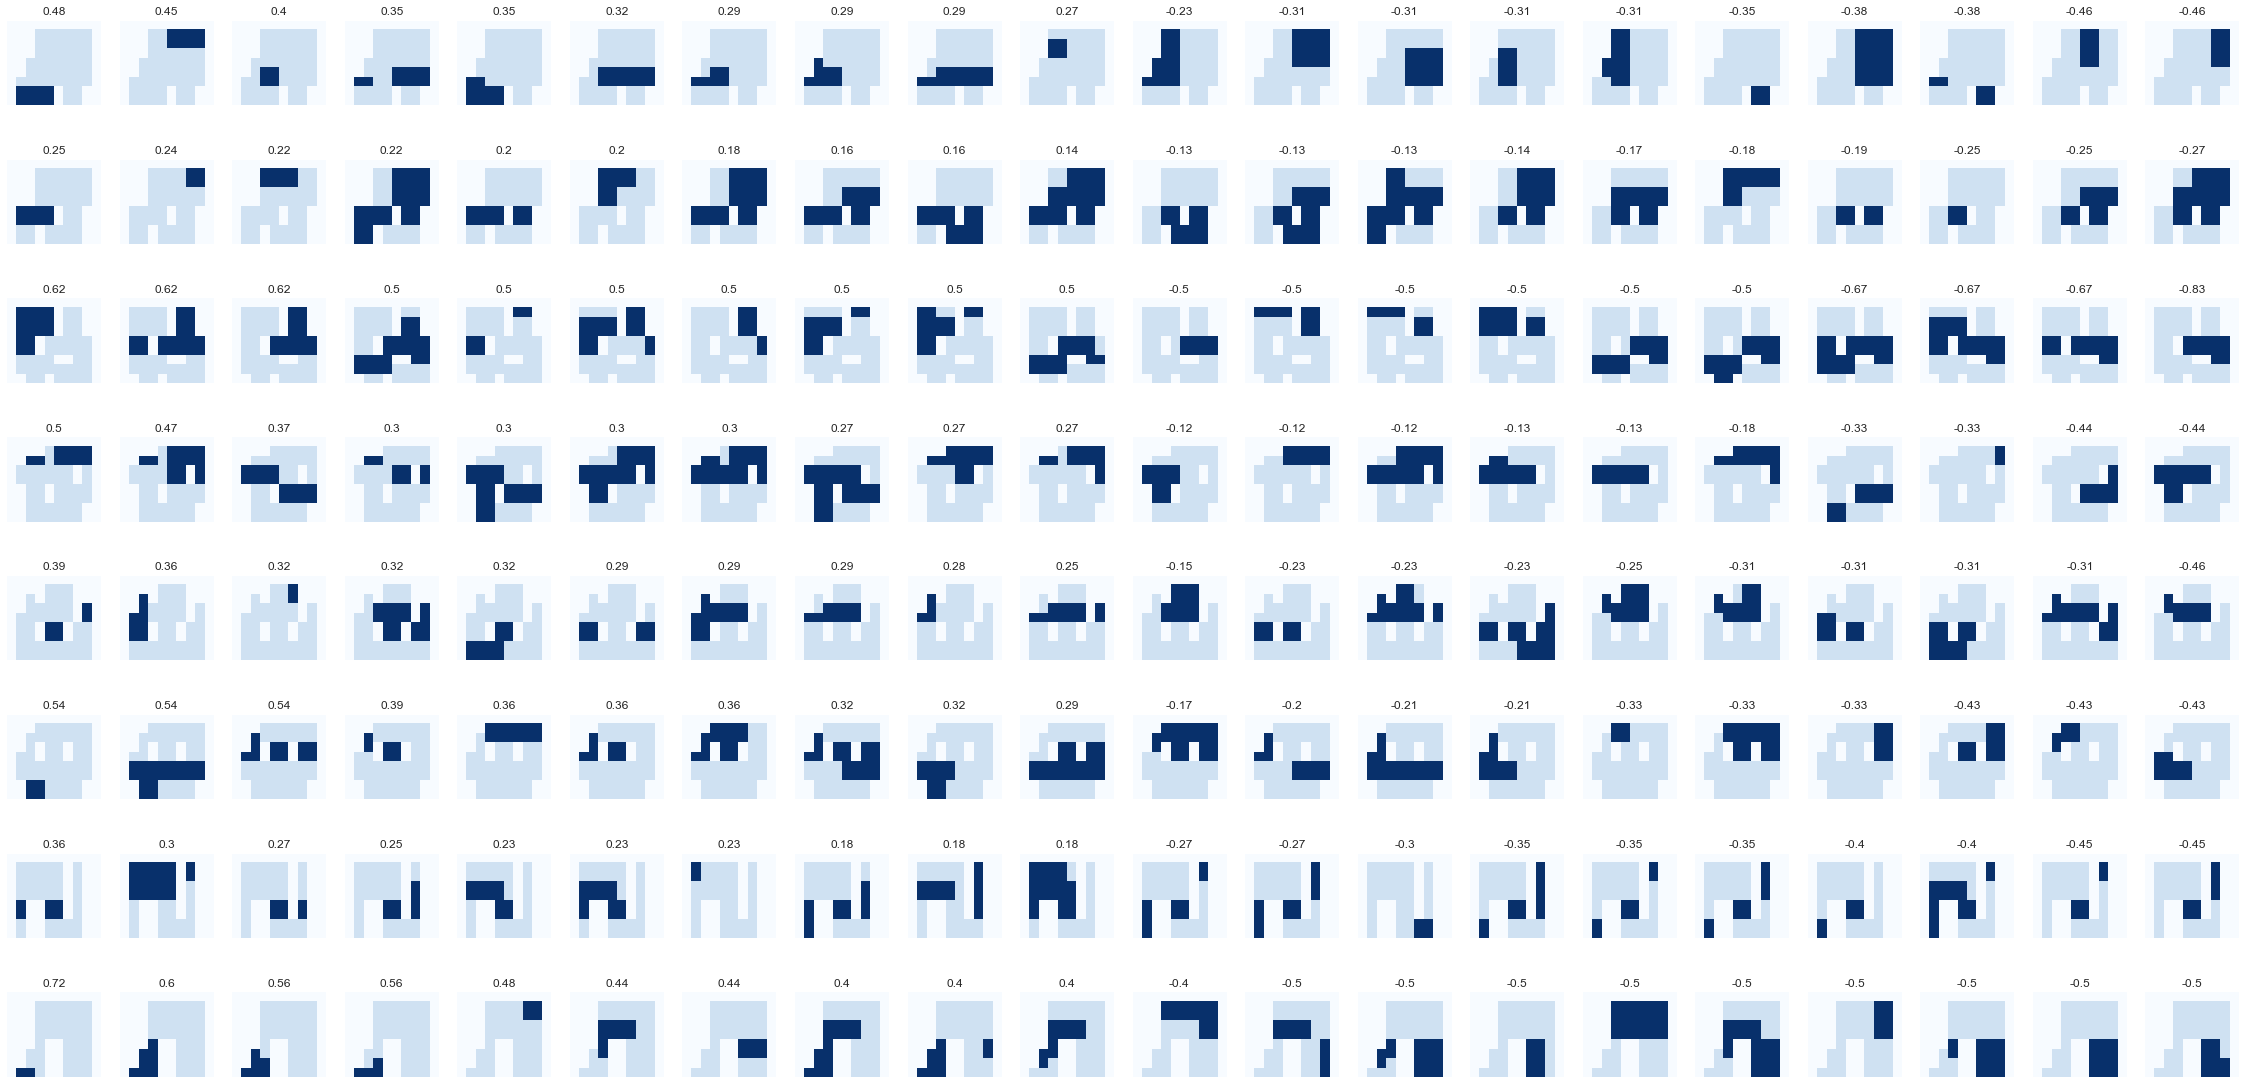

In [600]:
n_chunks = 10

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff_mean_perfect_only[df_proc_diff_mean_perfect_only.targetName==target].sort_values('diff', ascending=False).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,j].set_title(str(round(greatest_increase.loc[j,'diff'],2)))
        axs[i,j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff_mean_perfect_only[df_proc_diff_mean_perfect_only.targetName==target].sort_values('diff', ascending=True).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,n_chunks*2-1-j].set_title(str(round(greatest_increase.loc[j,'diff'],2)))
        axs[i,n_chunks*2-1-j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Blues', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

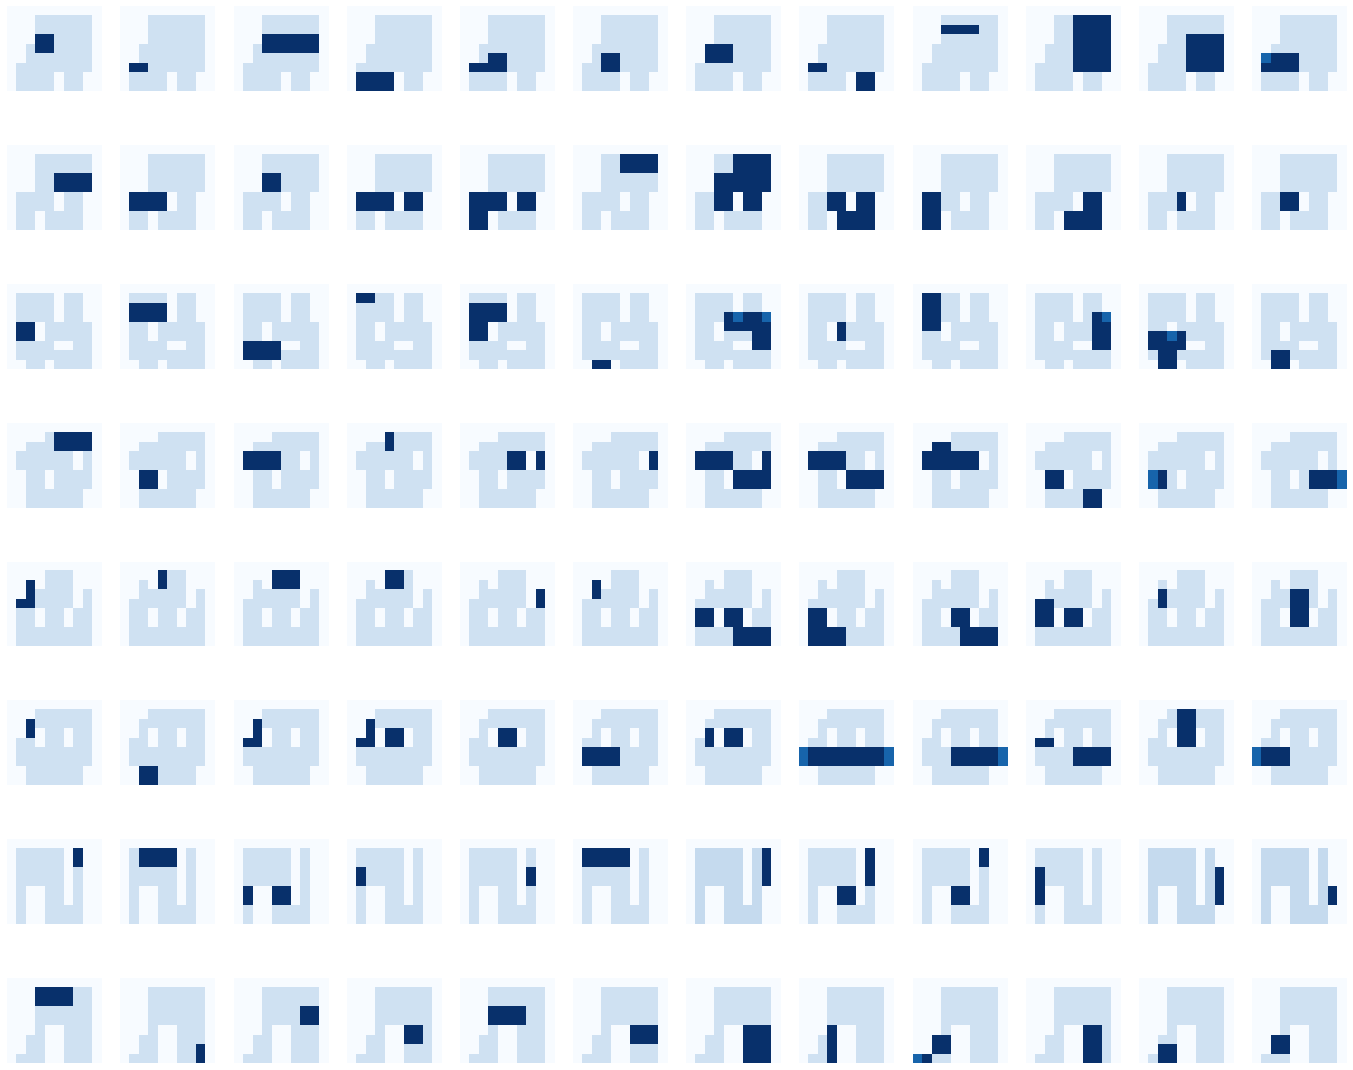

In [532]:
n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff_double_perfect[df_proc_diff_double_perfect.targetName==target].sort_values('diff', ascending=False).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff_double_perfect[df_proc_diff_double_perfect.targetName==target].sort_values('diff', ascending=True).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,n_chunks*2-1-j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Blues', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

### Visualizations of top chunks

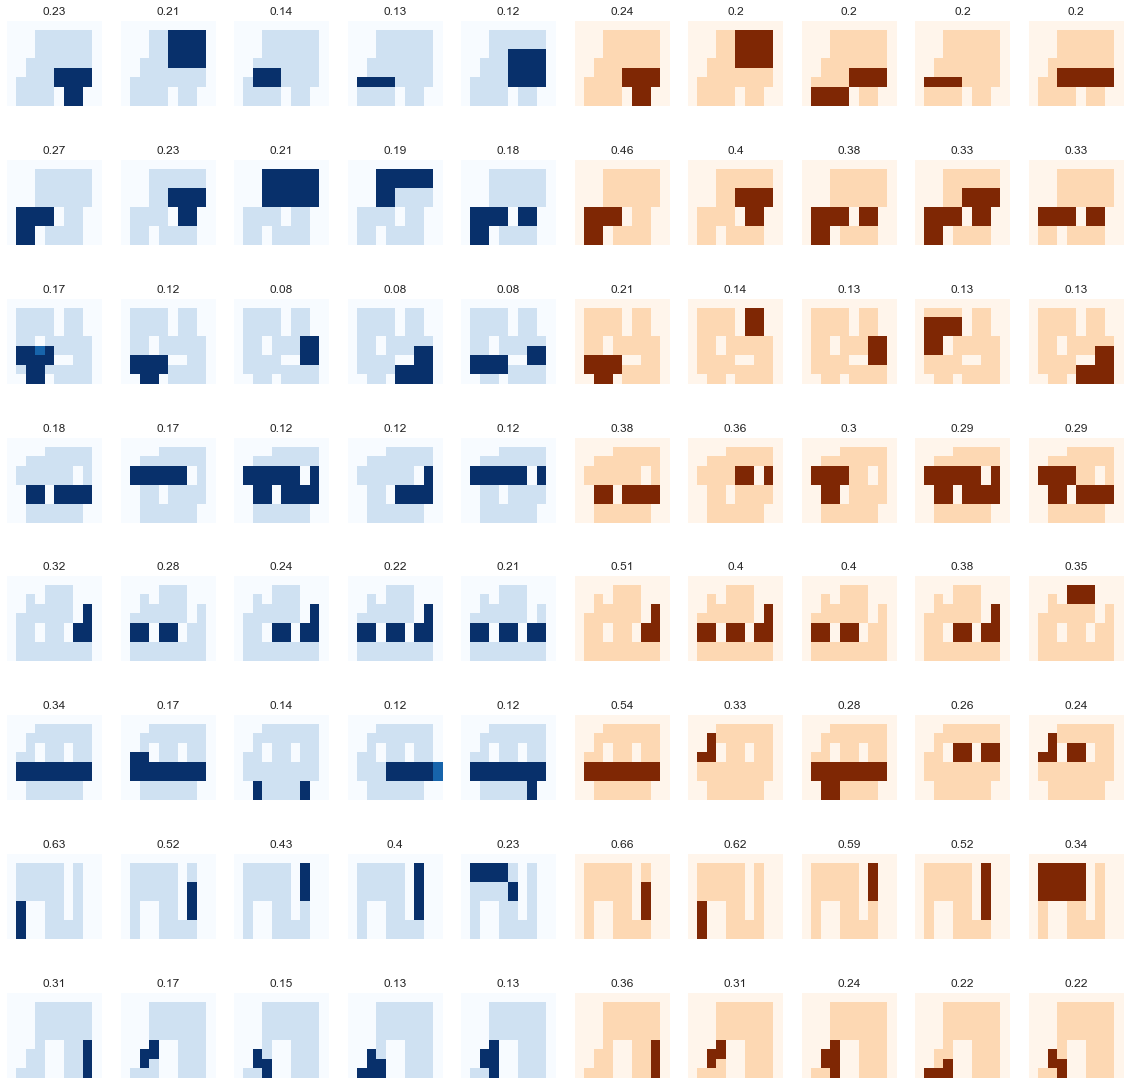

In [96]:
# All RECONSTRUCTIONS Most popular chunks in each phase

df = df_popular_chunks[df_popular_chunks.chunk_window>2]

n_chunks = 5

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        most_popular = df[(df.targetName==target) &
                          (df.phase=='pre')].sort_values('built_by_ppt_proportion', ascending=False).reset_index()
        axs[i,j].set_title(str(round(most_popular.loc[j,'built_by_ppt_proportion'],2)))
        axs[i,j].axis('off')
        drawing.show_chunk([most_popular.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        most_popular = df[(df.targetName==target) &
                          (df.phase=='post')].sort_values('built_by_ppt_proportion', ascending=False).reset_index()
#         axs[i,n_chunks*2-1-j].set_title(str(round(most_popular.loc[j,'built_by_ppt'],2)))
#         axs[i,n_chunks*2-1-j].axis('off')
#         drawing.show_chunk([most_popular.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Reds', cropped=True)
        axs[i,int(j+n_chunks)].set_title(str(round(most_popular.loc[j,'built_by_ppt_proportion'],2)))
        axs[i,int(j+n_chunks)].axis('off')
        drawing.show_chunk([most_popular.loc[j,'chunk']], axs[i,int(j+n_chunks)], target=target, cmap='Oranges', cropped=True)

# decreasing popularity from left to right on both sides. Right is post

NameError: name 'df_popular_chunks_perfect' is not defined

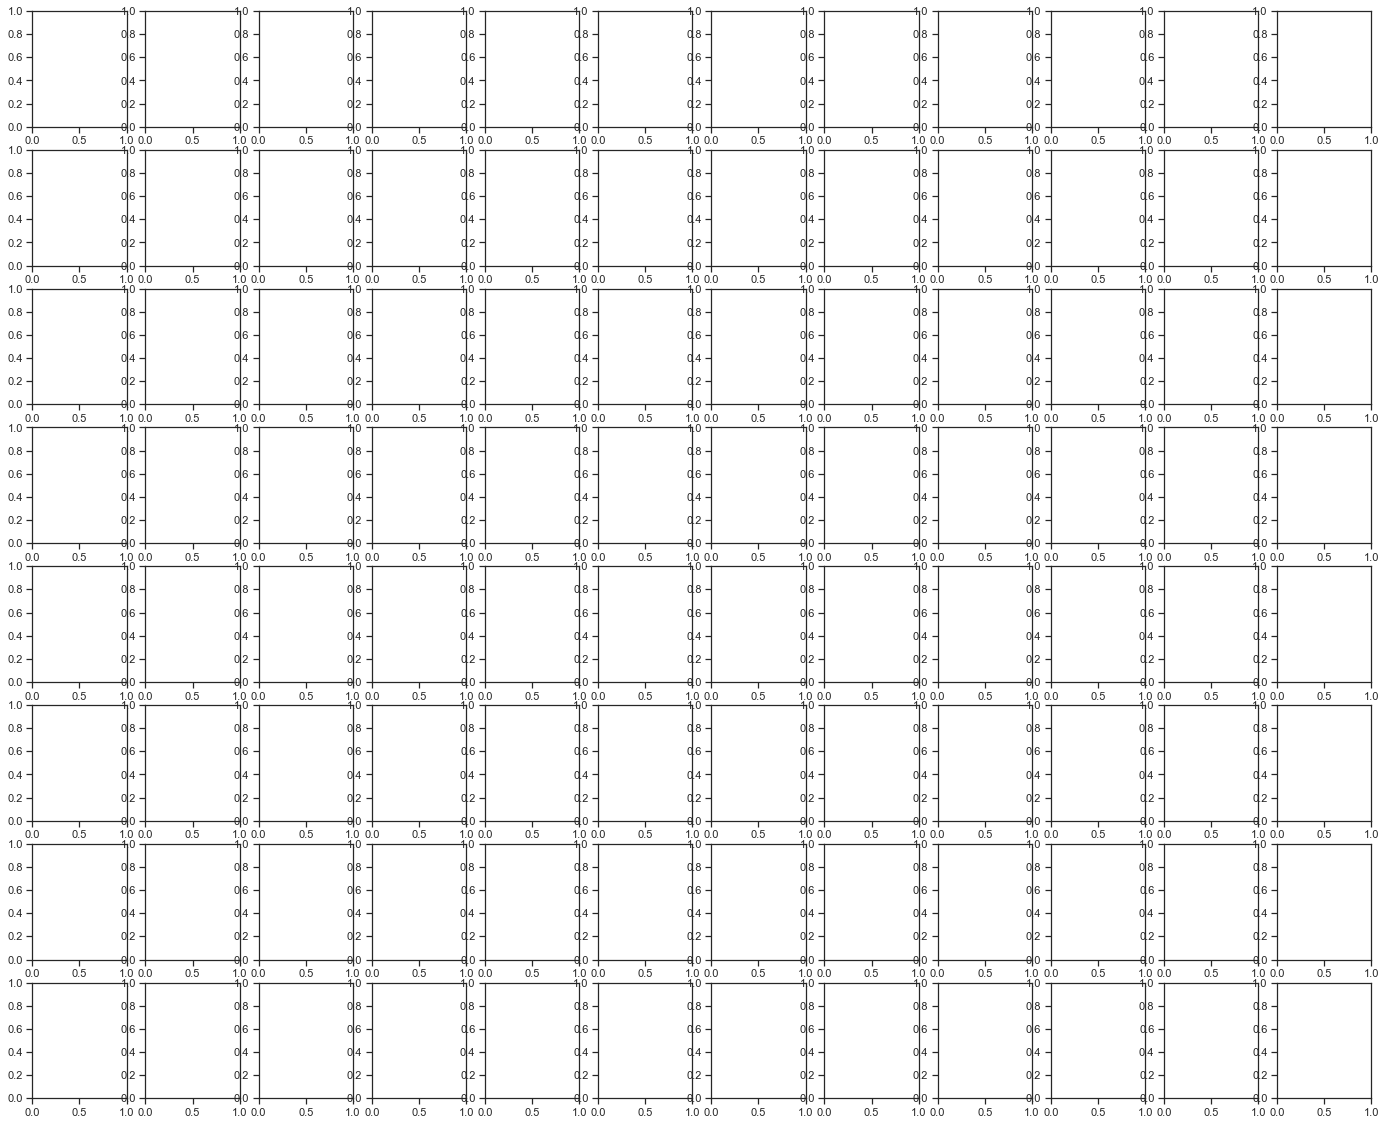

In [60]:
# PERFECT RECONSTRUCTIONS Most popular chunks in each phase

n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        most_popular = df_popular_chunks_perfect[(df_popular_chunks_perfect.targetName==target) &
                                                       (df_popular_chunks_perfect.phase=='pre')].sort_values('built_by_ppt', ascending=False).reset_index()
        axs[i,j].set_title(str(round(most_popular.loc[j,'built_by_ppt_proportion'],2)))
        axs[i,j].axis('off')
        drawing.show_chunk([most_popular.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        most_popular = df_popular_chunks_perfect[(df_popular_chunks_perfect.targetName==target) &
                                                       (df_popular_chunks_perfect.phase=='post')].sort_values('built_by_ppt', ascending=False).reset_index()
#         axs[i,n_chunks*2-1-j].set_title(str(round(most_popular.loc[j,'built_by_ppt'],2)))
#         axs[i,n_chunks*2-1-j].axis('off')
#         drawing.show_chunk([most_popular.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Reds', cropped=True)
        axs[i,int(j+n_chunks)].set_title(str(round(most_popular.loc[j,'built_by_ppt_proportion'],2)))
        axs[i,int(j+n_chunks)].axis('off')
        drawing.show_chunk([most_popular.loc[j,'chunk']], axs[i,int(j+n_chunks)], target=target, cmap='Oranges', cropped=True)

# decreasing popularity from left to right on both sides. Right is post

### export top procedural chunks from each phase

In [624]:
df_popular_chunks.sort_values('built_by_ppt_proportion', ascending=False).reset_index()

index                                              chunk phase  \
0       726  0000000000000000000000000000000000000000000000...   pre   
1       725  0000000000000000000000000000000000000000000000...  post   
2         1  0000000000000000000000000000000000000000000000...  post   
3        33  0000000000000000000000000000000000000000000000...  post   
4        22  0000000000000000000000000000000000000000000000...  post   
...     ...                                                ...   ...   
1087    597  0000000000000000000000000000000000000000000000...   pre   
1088    588  0000000000000000000000000000000000000000000000...  post   
1089    581  0000000000000000000000000000000000000000000000...  post   
1090    580  0000000000000000000000000000000000000000000000...   pre   
1091   1091  0000000000000000000000000000000000000000000000...  post   

             targetName  chunk_window  built_by_ppt_proportion  \
0     hand_selected_012           2.0                 0.780952   
1     hand_selected_012           2.0                 0.771429   
2     hand_selected_009           2.0                 0.742857   
3     hand_selected_012           2.0                 0.733333   
4     hand_selected_012           2.0                 0.733333   
...                 ...           ...                      ...   
1087  hand_selected_008           6.0                 0.000000   
1088  hand_selected_008           4.0                 0.000000   
1089  hand_selected_012           5.0                 0.000000   
1090  hand_selected_008           3.0                 0.000000   
1091  hand_selected_016           6.0                 0.000000   

      built_by_ppt_total    height  area  
0                   82.0  3.000000     2  
1                   81.0  3.000000     2  
2                   78.0  5.000000     2  
3                   77.0  3.000000     2  
4                   77.0  5.000000     2  
...                  ...       ...   ...  
1087                 0.0  5.000000    30  
1088                 0.0  5.800000    20  
1089                 0.0  5.000000    14  
1090                 0.0  5.000000    10  
1091                 0.0  1.954545    12  

[1092 rows x 9 columns]

In [620]:
df_popular_chunks_perfect.sort_values('built_by_ppt_proportion', ascending=False).reset_index()

index                                              chunk phase  \
0        60  0000000000000000000000000000000000000000000000...  post   
1       103  0000000000000000000000000000000000000000000000...  post   
2       853  0000000000000000000000000000000000000000000000...  post   
3        38  0000000000000000000000000000000000000000000000...  post   
4        14  0000000000000000000000000000000000000000000000...  post   
...     ...                                                ...   ...   
1146    560  0000000000000000000000000000000000000000000000...  post   
1147    562  0000000000000000000000000000000000000000000000...   pre   
1148    563  0000000000000000000000000000000000000000000000...   pre   
1149    564  0000000000000000000000000000000000000000000000...   pre   
1150    575  0000000000000000000000000000000000000000000000...  post   

             targetName  chunk_window  built_by_ppt_proportion  \
0     hand_selected_005           2.0                 0.485714   
1     hand_selected_005           2.0                 0.466667   
2     hand_selected_012           2.0                 0.419048   
3     hand_selected_012           2.0                 0.419048   
4     hand_selected_012           2.0                 0.419048   
...                 ...           ...                      ...   
1146  hand_selected_011           3.0                 0.000000   
1147  hand_selected_011           3.0                 0.000000   
1148  hand_selected_011           4.0                 0.000000   
1149  hand_selected_011           5.0                 0.000000   
1150  hand_selected_006           5.0                 0.000000   

      built_by_ppt_total    height  area  
0                   51.0  3.000000     4  
1                   49.0  5.000000     8  
2                   44.0  3.000000     2  
3                   44.0  3.000000     2  
4                   44.0  7.000000     2  
...                  ...       ...   ...  
1146                 0.0  2.333333    12  
1147                 0.0  2.333333    12  
1148                 0.0  1.000000     8  
1149                 0.0  2.000000    16  
1150                 0.0  6.900000    10  

[1151 rows x 9 columns]

In [637]:
from sklearn.metrics import jaccard_score

In [670]:
# perfect or all
#df = df_popular_chunks_perfect
df = df_popular_chunks

In [671]:
chunk_sets_both = {}

for target in targets:
    
    chunk_sets_both[target] = {}
    
    chunk_sets_both[target]['perceptual_set'] = set(perceptual_chunk_counters[target].keys())
    chunk_sets_both[target]['procedural_set'] = set(df[(df.targetName==target)].chunk.unique())
    chunk_sets_both[target]['intersection'] = chunk_sets_both[target]['perceptual_set'].intersection(chunk_sets_both[target]['procedural_set'])
    chunk_sets_both[target]['union'] = chunk_sets_both[target]['perceptual_set'].union(chunk_sets_both[target]['procedural_set'])
    chunk_sets_both[target]['IOU'] = len(chunk_sets_both[target]['intersection'])/len(chunk_sets_both[target]['union'])
    chunk_sets_both[target]['percent_perceptual'] = len(chunk_sets_both[target]['intersection'])/len(chunk_sets_both[target]['perceptual_set'])

#     print('perceptual set: ' + str(len(chunk_sets_both[target]['perceptual_set'] )))
#     print('procedural set: ' + str(len(chunk_sets_both[target]['procedural_set'] )))
    
#     print(phase + ' intersection:' + str(len(chunk_sets_both[target]['intersection'])))
#     print(phase + ' union: ' + str(len(chunk_sets_both[target]['union'])))
#     print('IOU: ' + str(len(chunk_sets_both[target]['intersection'])/len(chunk_sets_both[target]['union'])))
#     print('')

In [672]:
[chunk_sets_both[target]['percent_perceptual'] for target in targets]

[0.23636363636363636,
 0.7727272727272727,
 0.23333333333333334,
 0.18888888888888888,
 0.1346153846153846,
 0.14736842105263157,
 0.25,
 0.34285714285714286]

In [673]:
np.mean([chunk_sets_both[target]['percent_perceptual'] for target in targets])

0.2882692599797863

In [674]:
for target in targets:
    
    perceptual_set = set(perceptual_chunk_counters[target].keys())
    procedural_set = set(df[(df.targetName==target)].chunk.unique())
    intersection = perceptual_set.intersection(procedural_set)
    union = perceptual_set.union(procedural_set)
    
    print('perceptual set: ' + str(len(perceptual_set)))
    print('procedural set: ' + str(len(procedural_set)))
    
    print(phase + ' intersection:' + str(len(intersection)))
    print(phase + ' union: ' + str(len(union)))
    print('IOU: ' + str(len(intersection)/len(union)))
    print('')

perceptual set: 55
procedural set: 97
post intersection:13
post union: 139
IOU: 0.09352517985611511

perceptual set: 22
procedural set: 72
post intersection:17
post union: 77
IOU: 0.22077922077922077

perceptual set: 60
procedural set: 103
post intersection:14
post union: 149
IOU: 0.09395973154362416

perceptual set: 90
procedural set: 85
post intersection:17
post union: 158
IOU: 0.10759493670886076

perceptual set: 104
procedural set: 86
post intersection:14
post union: 176
IOU: 0.07954545454545454

perceptual set: 95
procedural set: 100
post intersection:14
post union: 181
IOU: 0.07734806629834254

perceptual set: 40
procedural set: 81
post intersection:10
post union: 111
IOU: 0.09009009009009009

perceptual set: 35
procedural set: 98
post intersection:12
post union: 121
IOU: 0.09917355371900827



In [654]:
for target in targets:
    perceptual_set = set(perceptual_chunk_counters[target].keys())
    
    for phase in ['pre','post']:
        procedural_set = set(df[(df.targetName==target) &
                                (df.phase==phase)].chunk.unique())
        
        intersection = perceptual_set.intersection(procedural_set)
        union = perceptual_set.union(procedural_set)
        
        print(phase + ' intersection:' + str(len(intersection)))
        print(phase + ' union: ' + str(len(union)))
        print('IOU: ' + str(len(intersection)/len(union)))
        print('')

pre intersection:9
pre union: 123
IOU: 0.07317073170731707

post intersection:10
post union: 113
IOU: 0.08849557522123894

pre intersection:16
pre union: 65
IOU: 0.24615384615384617

post intersection:14
post union: 67
IOU: 0.208955223880597

pre intersection:11
pre union: 129
IOU: 0.08527131782945736

post intersection:13
post union: 118
IOU: 0.11016949152542373

pre intersection:18
pre union: 144
IOU: 0.125

post intersection:17
post union: 139
IOU: 0.1223021582733813

pre intersection:13
pre union: 163
IOU: 0.07975460122699386

post intersection:14
post union: 158
IOU: 0.08860759493670886

pre intersection:14
pre union: 167
IOU: 0.08383233532934131

post intersection:13
post union: 152
IOU: 0.08552631578947369

pre intersection:10
pre union: 97
IOU: 0.10309278350515463

post intersection:9
post union: 97
IOU: 0.09278350515463918

pre intersection:9
pre union: 99
IOU: 0.09090909090909091

post intersection:10
post union: 93
IOU: 0.10752688172043011



In [627]:
perceptual_chunk_counters

{'hand_selected_004': {'000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011000000000001100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000': 40,
  '000000000000000000000000000000000000000000000000000000000000000001110000000000111000000000011100000000001110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000': 20,
  '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111000000000011100000000001110000000000111000000000011100000000001110000000000000000000000000000000000000000000000000000000000000000000000': 17,
  '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111000000011111100000001111110000000111111000000011111100000001111110000000000000000000000000000000000000000000000000000000000000000000000': 14,
  '

## Integrate perceptual chunk info

In [200]:
# load dictionary of dictionaries- target: chunk: count
perceptual_chunk_counters = pickle.load(open("perceptual_chunk_counters.p", "rb" ))

def check_chunk(chunk, target, perceptual_chunk_counters):
    if chunk in perceptual_chunk_counters[target].keys():
        perceptual_count = perceptual_chunk_counters[target][chunk]
    else:
        perceptual_count = 0
    return perceptual_count
    
def add_perceptual_chunk_info(df):
    df['perceptual_count'] = df.apply(lambda row: check_chunk(row['chunk'], row['targetName'], perceptual_chunk_counters), axis=1)
    

In [ ]:
# load dataframe, add perc info, and save

df_name = 'df_name'

if False:
    df = pickle.load(open(df_name+".p", "rb" ))

    add_perceptual_chunk_info(df)

    pickle.dump(df_name, open(df_name+"_perc_counts"+".p", "wb" ))

    out_path = os.path.join(csv_dir, df_name + "_perc_counts"+".csv")
    df.to_csv(out_path)

In [334]:
df_popular_chunks_mean

chunk phase  \
0     0000000000000000000000000000000000000000000000...  post   
1     0000000000000000000000000000000000000000000000...  post   
2     0000000000000000000000000000000000000000000000...   pre   
3     0000000000000000000000000000000000000000000000...   pre   
4     0000000000000000000000000000000000000000000000...   pre   
...                                                 ...   ...   
1087  0000000000000000000000000000000000000000000000...  post   
1088  0000000000000000000000000000000000000000000000...   pre   
1089  0000000000000000000000000000000000000000000000...   pre   
1090  0000000000000000000000000000000000000000000000...  post   
1091  0000000000000000000000000000000000000000000000...  post   

             targetName  chunk_window  built_by_ppt    height  area  
0     hand_selected_008           2.0      0.561905  5.000000     2  
1     hand_selected_009           2.0      0.742857  5.000000     2  
2     hand_selected_008           2.0      0.323810  5.000000     2  
3     hand_selected_009           2.0      0.533333  5.000000     2  
4     hand_selected_012           2.0      0.057471  5.000000     2  
...                 ...           ...           ...       ...   ...  
1087  hand_selected_016           6.0      0.000000  1.590909    12  
1088  hand_selected_016           5.0      0.047619  1.944444    10  
1089  hand_selected_016           6.0      0.000000  2.863636    12  
1090  hand_selected_016           5.0      0.000000  1.500000    10  
1091  hand_selected_016           6.0      0.000000  1.954545    12  

[1092 rows x 7 columns]

### Properties of popular chunks

In [560]:
add_perceptual_chunk_info(df_chunk_use_separate_phases)

In [ ]:
# are higher up chunks built more frequently in post than in pre?

In [424]:
a = df_popular_chunks_mean.sort_values('built_by_ppt', ascending=False).reset_index().iloc[:200,:]

In [421]:
# a = df_popular_chunks_mean_perfect.sort_values('built_by_ppt', ascending=False).reset_index().iloc[:200,:]

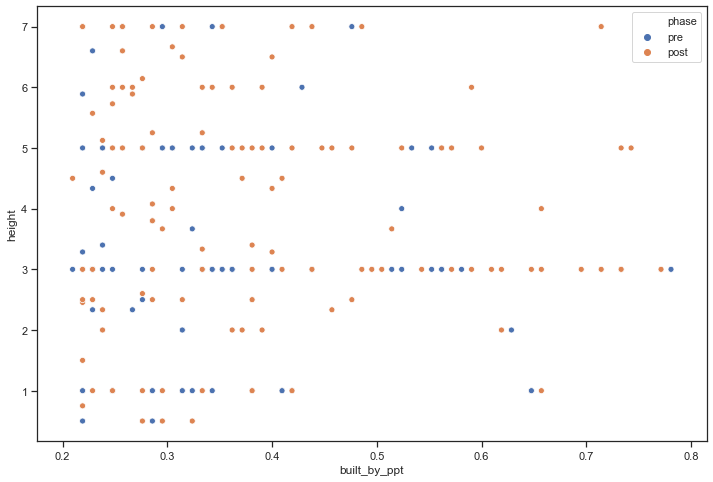

In [425]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.scatterplot(data=a, y='height', x='built_by_ppt', hue='phase')#, dodge=True, size=8, alpha=0.5)

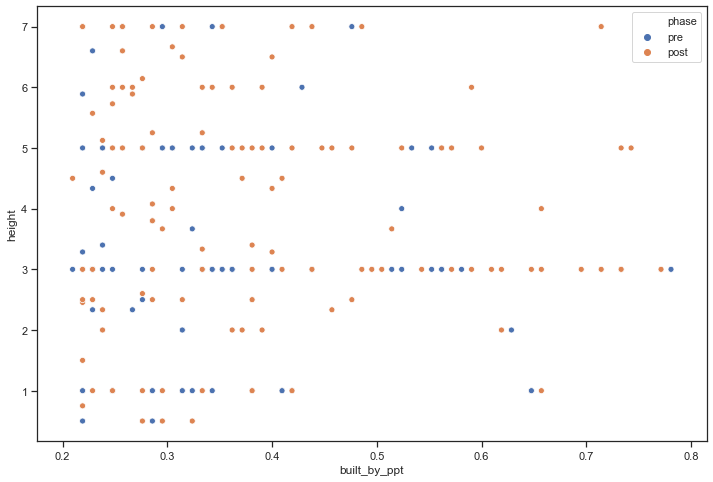

In [426]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.scatterplot(data=a, y='height', x='built_by_ppt', hue='phase')#, dodge=True, size=8, alpha=0.5)

In [491]:
df_popular_chunks_perfect

chunk phase  \
0     0000000000000000000000000000000000000000000000...  post   
1     0000000000000000000000000000000000000000000000...   pre   
2     0000000000000000000000000000000000000000000000...  post   
3     0000000000000000000000000000000000000000000000...  post   
4     0000000000000000000000000000000000000000000000...   pre   
...                                                 ...   ...   
1146  0000000000000000000000000000000000000000000000...   pre   
1147  0000000000000000000000000000000000000000000000...  post   
1148  0000000000000000000000000000000000000000000000...   pre   
1149  0000000000000000000000000000000000000000000000...  post   
1150  0000000000000000000000000000000000000000000000...   pre   

             targetName  chunk_window  built_by_ppt  built_by_ppt_proportion  \
0     hand_selected_008           2.0           0.0                 0.000000   
1     hand_selected_008           2.0           3.0                 0.028571   
2     hand_selected_008           2.0          30.0                 0.285714   
3     hand_selected_009           2.0          28.0                 0.266667   
4     hand_selected_008           2.0           9.0                 0.085714   
...                 ...           ...           ...                      ...   
1146  hand_selected_012           6.0           0.0                 0.000000   
1147  hand_selected_012           6.0          10.0                 0.095238   
1148  hand_selected_012           6.0           8.0                 0.076190   
1149  hand_selected_012           6.0          10.0                 0.095238   
1150  hand_selected_012           6.0           8.0                 0.076190   

        height  area  
0     7.000000     2  
1     7.000000     2  
2     5.000000     2  
3     5.000000     2  
4     5.000000     2  
...        ...   ...  
1146  5.363636    22  
1147  5.181818    22  
1148  5.181818    22  
1149  4.833333    24  
1150  4.833333    24  

[1151 rows x 8 columns]

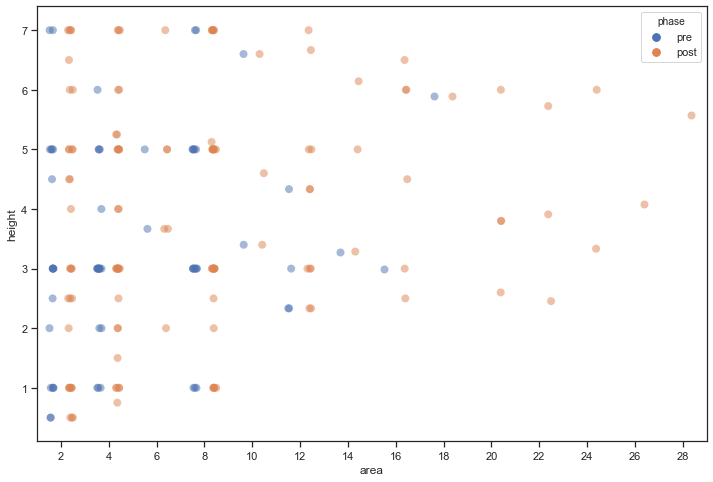

In [376]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.stripplot(data=a, x='area', y='height', hue='phase', dodge=True, size=8, alpha=0.5)

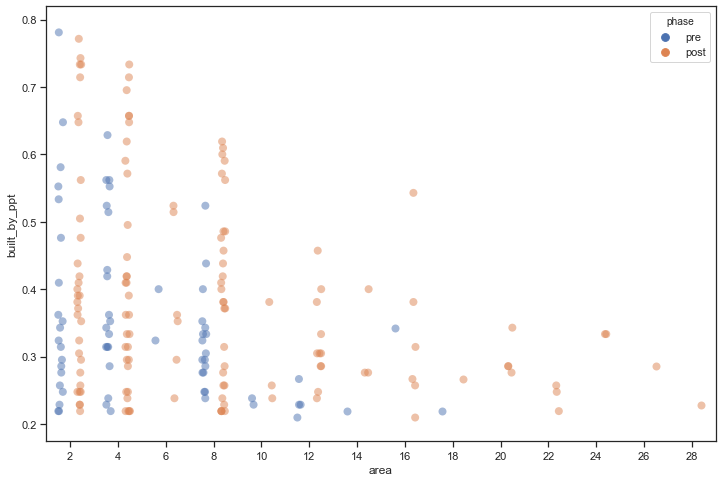

In [382]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.stripplot(data=a, x='area', y='built_by_ppt', hue='phase', dodge=True, size=8, alpha=0.5)

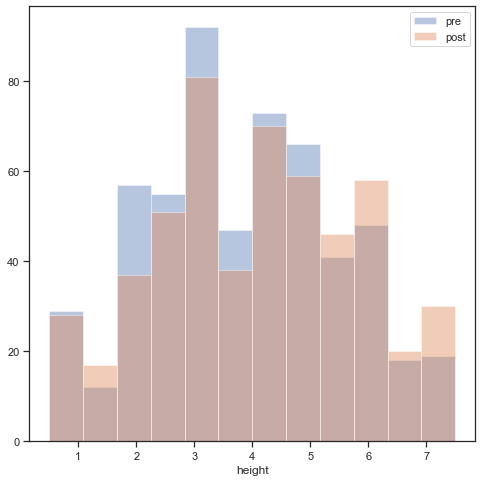

In [316]:
fig = plt.figure(figsize=(8,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.distplot(df_popular_chunks_mean[df_popular_chunks_mean.phase=='pre'].height, kde=False)
sns.distplot(df_popular_chunks_mean[df_popular_chunks_mean.phase=='post'].height, kde=False)
plt.legend(['pre','post'])

In [333]:
df_chunk_use_separate_phases

built_by_ppt                                              chunk  \
0                1.0  0000000000000000000000000000000000000000000000...   
1                0.0  0000000000000000000000000000000000000000000000...   
2                0.0  0000000000000000000000000000000000000000000000...   
3                1.0  0000000000000000000000000000000000000000000000...   
4                1.0  0000000000000000000000000000000000000000000000...   
...              ...                                                ...   
100795           0.0  0000000000000000000000000000000000000000000000...   
100796           0.0  0000000000000000000000000000000000000000000000...   
100797           0.0  0000000000000000000000000000000000000000000000...   
100798           0.0  0000000000000000000000000000000000000000000000...   
100799           0.0  0000000000000000000000000000000000000000000000...   

                                             chunk_source  chunk_window  \
0       pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...           2.0   
1       pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...           2.0   
2       pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...           2.0   
3       pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...           2.0   
4       pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...           2.0   
...                                                   ...           ...   
100795  post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...           6.0   
100796  post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...           6.0   
100797  post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...           6.0   
100798  post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...           6.0   
100799  post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...           6.0   

        n_builds_in_training_set  n_phase_recons phase  prop_containing_chunk  \
0                           54.0           105.0   pre               0.009524   
1                           44.0           105.0   pre               0.000000   
2                           32.0           105.0   pre               0.000000   
3                           28.0           105.0   pre               0.009524   
4                           23.0           105.0   pre               0.009524   
...                          ...             ...   ...                    ...   
100795                       5.0           105.0  post               0.000000   
100796                       5.0           105.0  post               0.000000   
100797                       4.0           105.0  post               0.000000   
100798                       4.0           105.0  post               0.000000   
100799                       4.0           105.0  post               0.000000   

        rank         targetName                                     gameID  \
0        0.0  hand_selected_004  0050-6c4598b0-4ba2-453b-9450-a2b56232ac90   
1        1.0  hand_selected_004  0050-6c4598b0-4ba2-453b-9450-a2b56232ac90   
2        2.0  hand_selected_004  0050-6c4598b0-4ba2-453b-9450-a2b56232ac90   
3        3.0  hand_selected_004  0050-6c4598b0-4ba2-453b-9450-a2b56232ac90   
4        4.0  hand_selected_004  0050-6c4598b0-4ba2-453b-9450-a2b56232ac90   
...      ...                ...                                        ...   
100795   7.0  hand_selected_016  9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3   
100796   8.0  hand_selected_016  9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3   
100797   9.0  hand_selected_016  9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3   
100798  10.0  hand_selected_016  9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3   
100799  11.0  hand_selected_016  9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3   

        perceptual_count    height  area  
0                      0  3.000000     8  
1                     40  1.000000     4  
2                      1  5.000000     8  
3                      0  2.500000     2  
4                      1  3.000000     4  
...                  ...       ...   .

In [249]:
importlib.reload(bc)

<module 'block_construction_helpers' from '../utils/block_construction_helpers.py'>

## left over code

chunk phase  \
0     0000000000000000000000000000000000000000000000...  post   
1     0000000000000000000000000000000000000000000000...  post   
2     0000000000000000000000000000000000000000000000...   pre   
3     0000000000000000000000000000000000000000000000...   pre   
4     0000000000000000000000000000000000000000000000...   pre   
...                                                 ...   ...   
1087  0000000000000000000000000000000000000000000000...  post   
1088  0000000000000000000000000000000000000000000000...   pre   
1089  0000000000000000000000000000000000000000000000...   pre   
1090  0000000000000000000000000000000000000000000000...  post   
1091  0000000000000000000000000000000000000000000000...  post   

             targetName  chunk_window  built_by_ppt  
0     hand_selected_008           2.0          59.0  
1     hand_selected_009           2.0          78.0  
2     hand_selected_008           2.0          34.0  
3     hand_selected_009           2.0          56.0  
4     hand_selected_012           2.0           5.0  
...                 ...           ...           ...  
1087  hand_selected_016           6.0           0.0  
1088  hand_selected_016           5.0           5.0  
1089  hand_selected_016           6.0           0.0  
1090  hand_selected_016           5.0           0.0  
1091  hand_selected_016           6.0           0.0  

[1092 rows x 5 columns]

In [87]:
#trying to find difference between pre and post here, to identify biggest movers:
df_proc_diff = df_popular_chunks.pivot(index=['targetName','chunk_window','chunk'], columns="phase", values="built_by_ppt").fillna(0)
df_proc_diff['diff'] = df_proc_diff['post'] - df_proc_diff['pre']
df_proc_diff = df_proc_diff.reset_index()
df_proc_diff

phase         targetName  chunk_window  \
0      hand_selected_004           2.0   
1      hand_selected_004           2.0   
2      hand_selected_004           2.0   
3      hand_selected_004           2.0   
4      hand_selected_004           2.0   
..                   ...           ...   
734    hand_selected_016           6.0   
735    hand_selected_016           6.0   
736    hand_selected_016           6.0   
737    hand_selected_016           6.0   
738    hand_selected_016           6.0   

phase                                              chunk  post   pre  diff  
0      0000000000000000000000000000000000000000000000...   0.0   0.0   0.0  
1      0000000000000000000000000000000000000000000000...   0.0   0.0   0.0  
2      0000000000000000000000000000000000000000000000...  44.0  44.0   0.0  
3      0000000000000000000000000000000000000000000000...  23.0  15.0   8.0  
4      0000000000000000000000000000000000000000000000...  40.0  32.0   8.0  
..                                                   ...   ...   ...   ...  
734    0000000000000000000000000000000000000000000000...   0.0   0.0   0.0  
735    0000000000000000000000000000000000000000000000...  13.0   6.0   7.0  
736    0000000000000000000000000000000000000000000000...   0.0   0.0   0.0  
737    0000000000000000000000000000000000000000000000...   0.0   0.0   0.0  
738    0000000000000000000000000000000000000000000000...   0.0   0.0   0.0  

[739 rows x 6 columns]

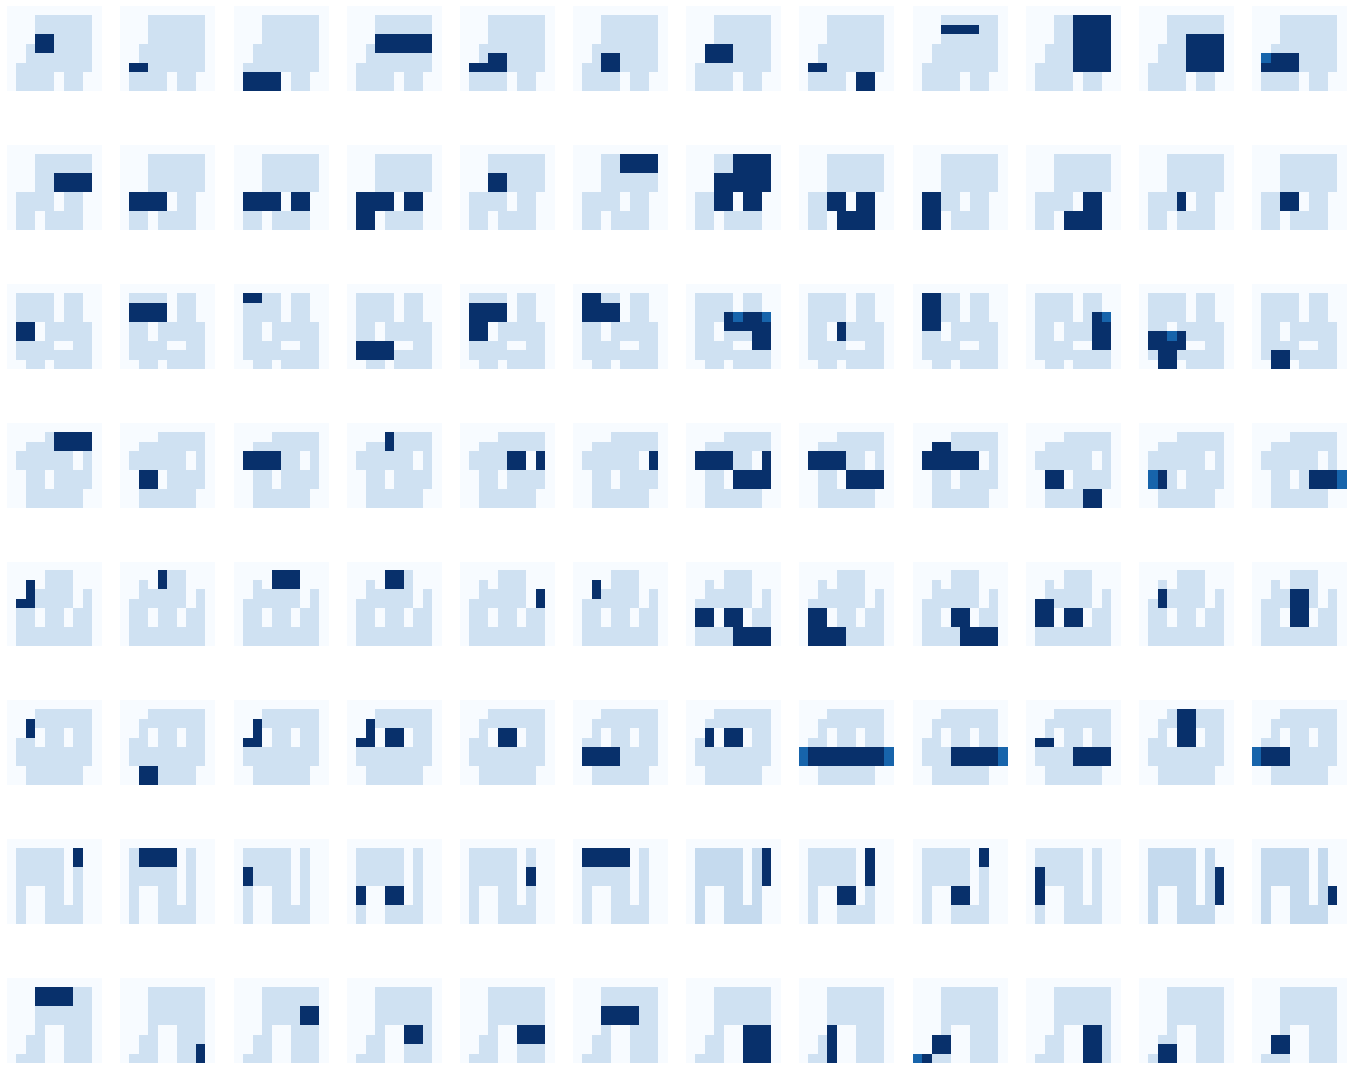

In [142]:
n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff[df_proc_diff.targetName==target].sort_values('diff', ascending=False).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff[df_proc_diff.targetName==target].sort_values('diff', ascending=True).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,n_chunks*2-1-j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Blues', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

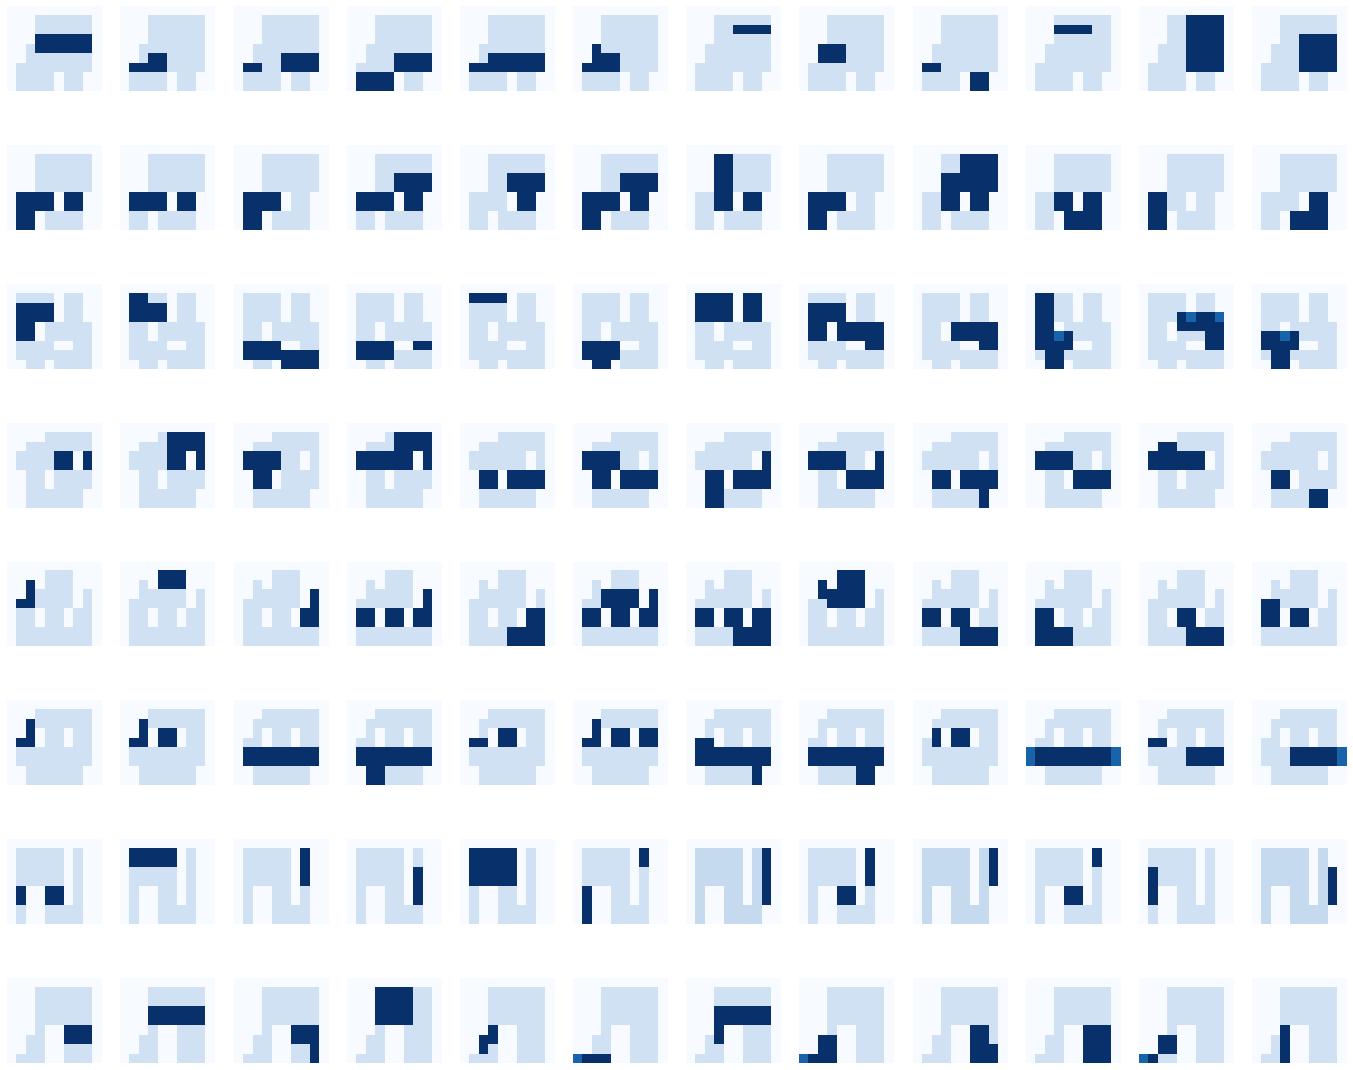

In [145]:
# Only chunks with multiple blocks

n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff[(df_proc_diff.targetName==target) & (df_proc_diff.chunk_window>2)].sort_values('diff', ascending=False).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff[(df_proc_diff.targetName==target) & (df_proc_diff.chunk_window>2)].sort_values('diff', ascending=True).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,n_chunks*2-1-j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Blues', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

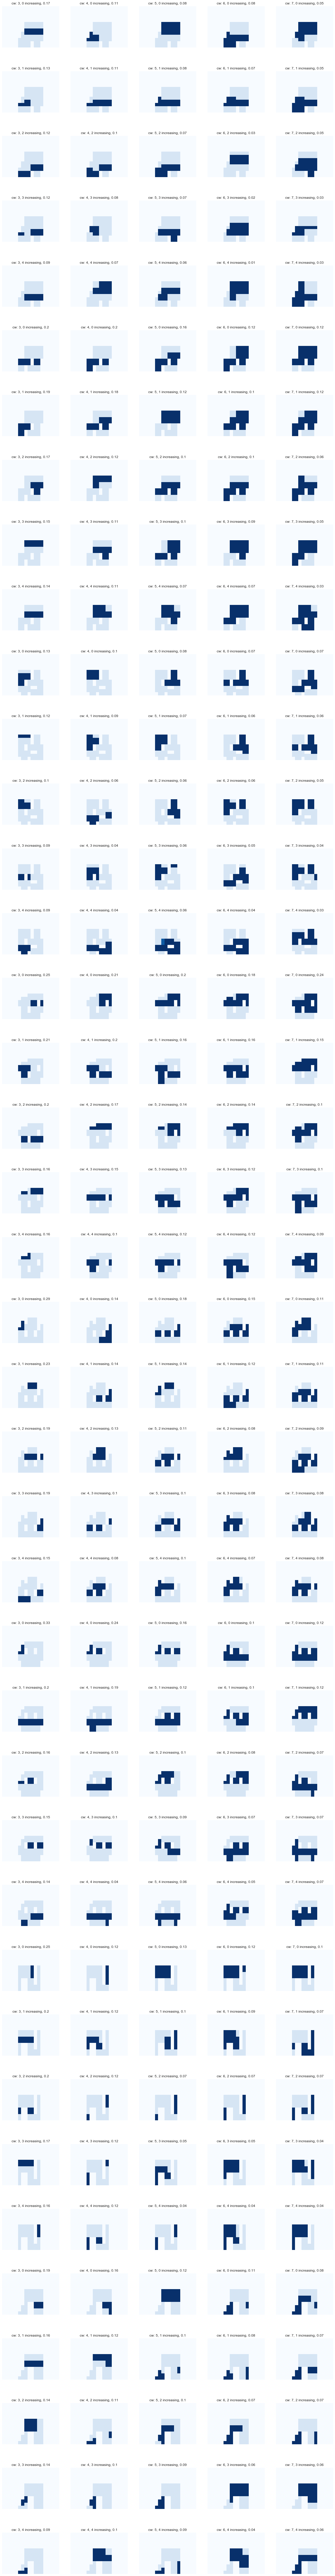

In [326]:
# plot chunks of highest increase

nchunks = 5

fig, axs = plt.subplots(len(targets)*nchunks, len(window_sizes), figsize=(4*len(window_sizes),4*len(targets)*nchunks))

for i, target in enumerate(targets):
    for j, chunk_window in enumerate(window_sizes):
        
        df_subset = df_pivot[(df_pivot.targetName==target) & (df_pivot.chunk_window==chunk_window)]
        
        #for ascending in [True, False]:
        
        df_subset_sorted = df_subset.sort_values(by='diff', ascending=False).reset_index()

        for k in range(0,nchunks):
            chunk = df_subset_sorted.loc[k,'chunk']
            drawing.show_chunk([chunk], axs[i*nchunks+k,j], target=target)
            axs[i*nchunks+k,j].set_title('cw: ' + str(chunk_window) + ', ' + str(k) + ' increasing, '  + str(round(df_subset_sorted.loc[k,'diff'],2)))
            axs[i*nchunks+k,j].axis('off')
            

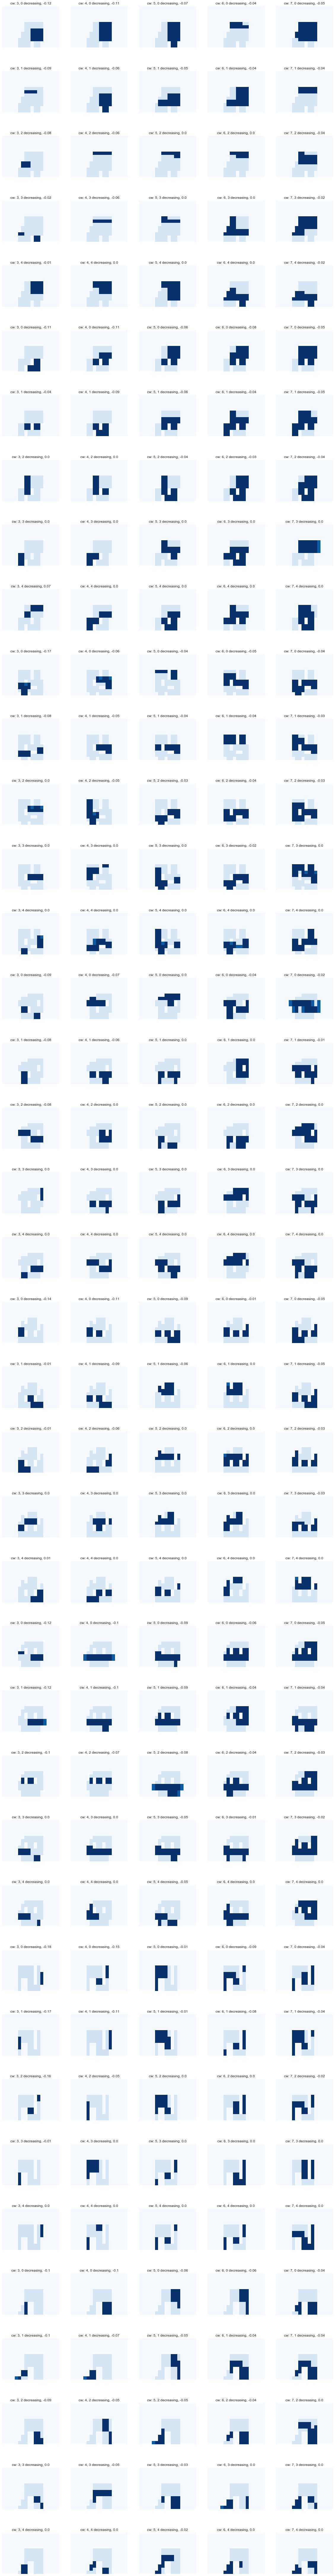

In [327]:
# plot chunks of highest decrease

nchunks = 5

fig, axs = plt.subplots(len(targets)*nchunks, len(window_sizes), figsize=(4*len(window_sizes),4*len(targets)*nchunks))

for i, target in enumerate(targets):
    for j, chunk_window in enumerate(window_sizes):
        
        df_subset = df_pivot[(df_pivot.targetName==target) & (df_pivot.chunk_window==chunk_window)]
        
        #for ascending in [True, False]:
        
        df_subset_sorted = df_subset.sort_values(by='diff', ascending=True).reset_index()

        for k in range(0,nchunks):
            chunk = df_subset_sorted.loc[k,'chunk']
            drawing.show_chunk([chunk], axs[i*nchunks+k,j], target=target)
            axs[i*nchunks+k,j].set_title('cw: ' + str(chunk_window) + ', ' + str(k) + ' decreasing, '  + str(round(df_subset_sorted.loc[k,'diff'],2)))
            axs[i*nchunks+k,j].axis('off')
            

#### frequency of chunk appearance

rank = popularity of chunk in perfect reconstructions. I.e. rank=0 means the most popular chunk

/Users/will/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 720x432 with 0 Axes>

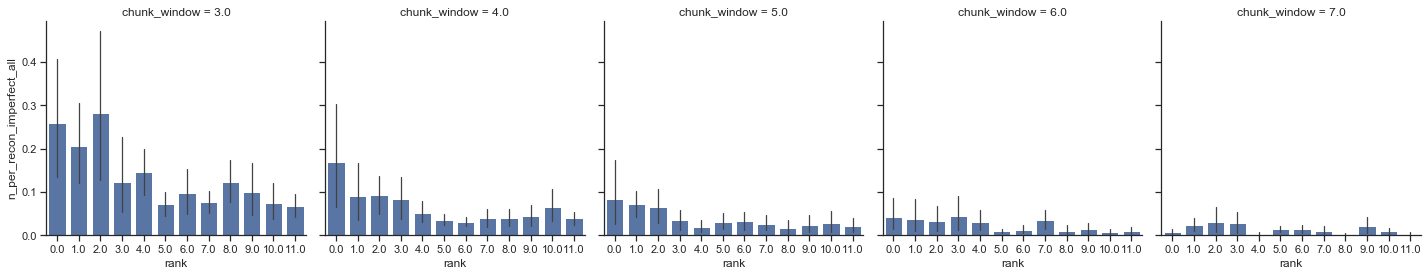

In [191]:
# How often were most popular chunks used in imperfect reconstructions?

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_top_chunks, col="chunk_window", height=4)
g.map(sns.barplot, "rank", "n_per_recon_imperfect_all");
# g.map(sns.pointplot, "rank","num_imperfect_post", color='orange');

/Users/will/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 720x432 with 0 Axes>

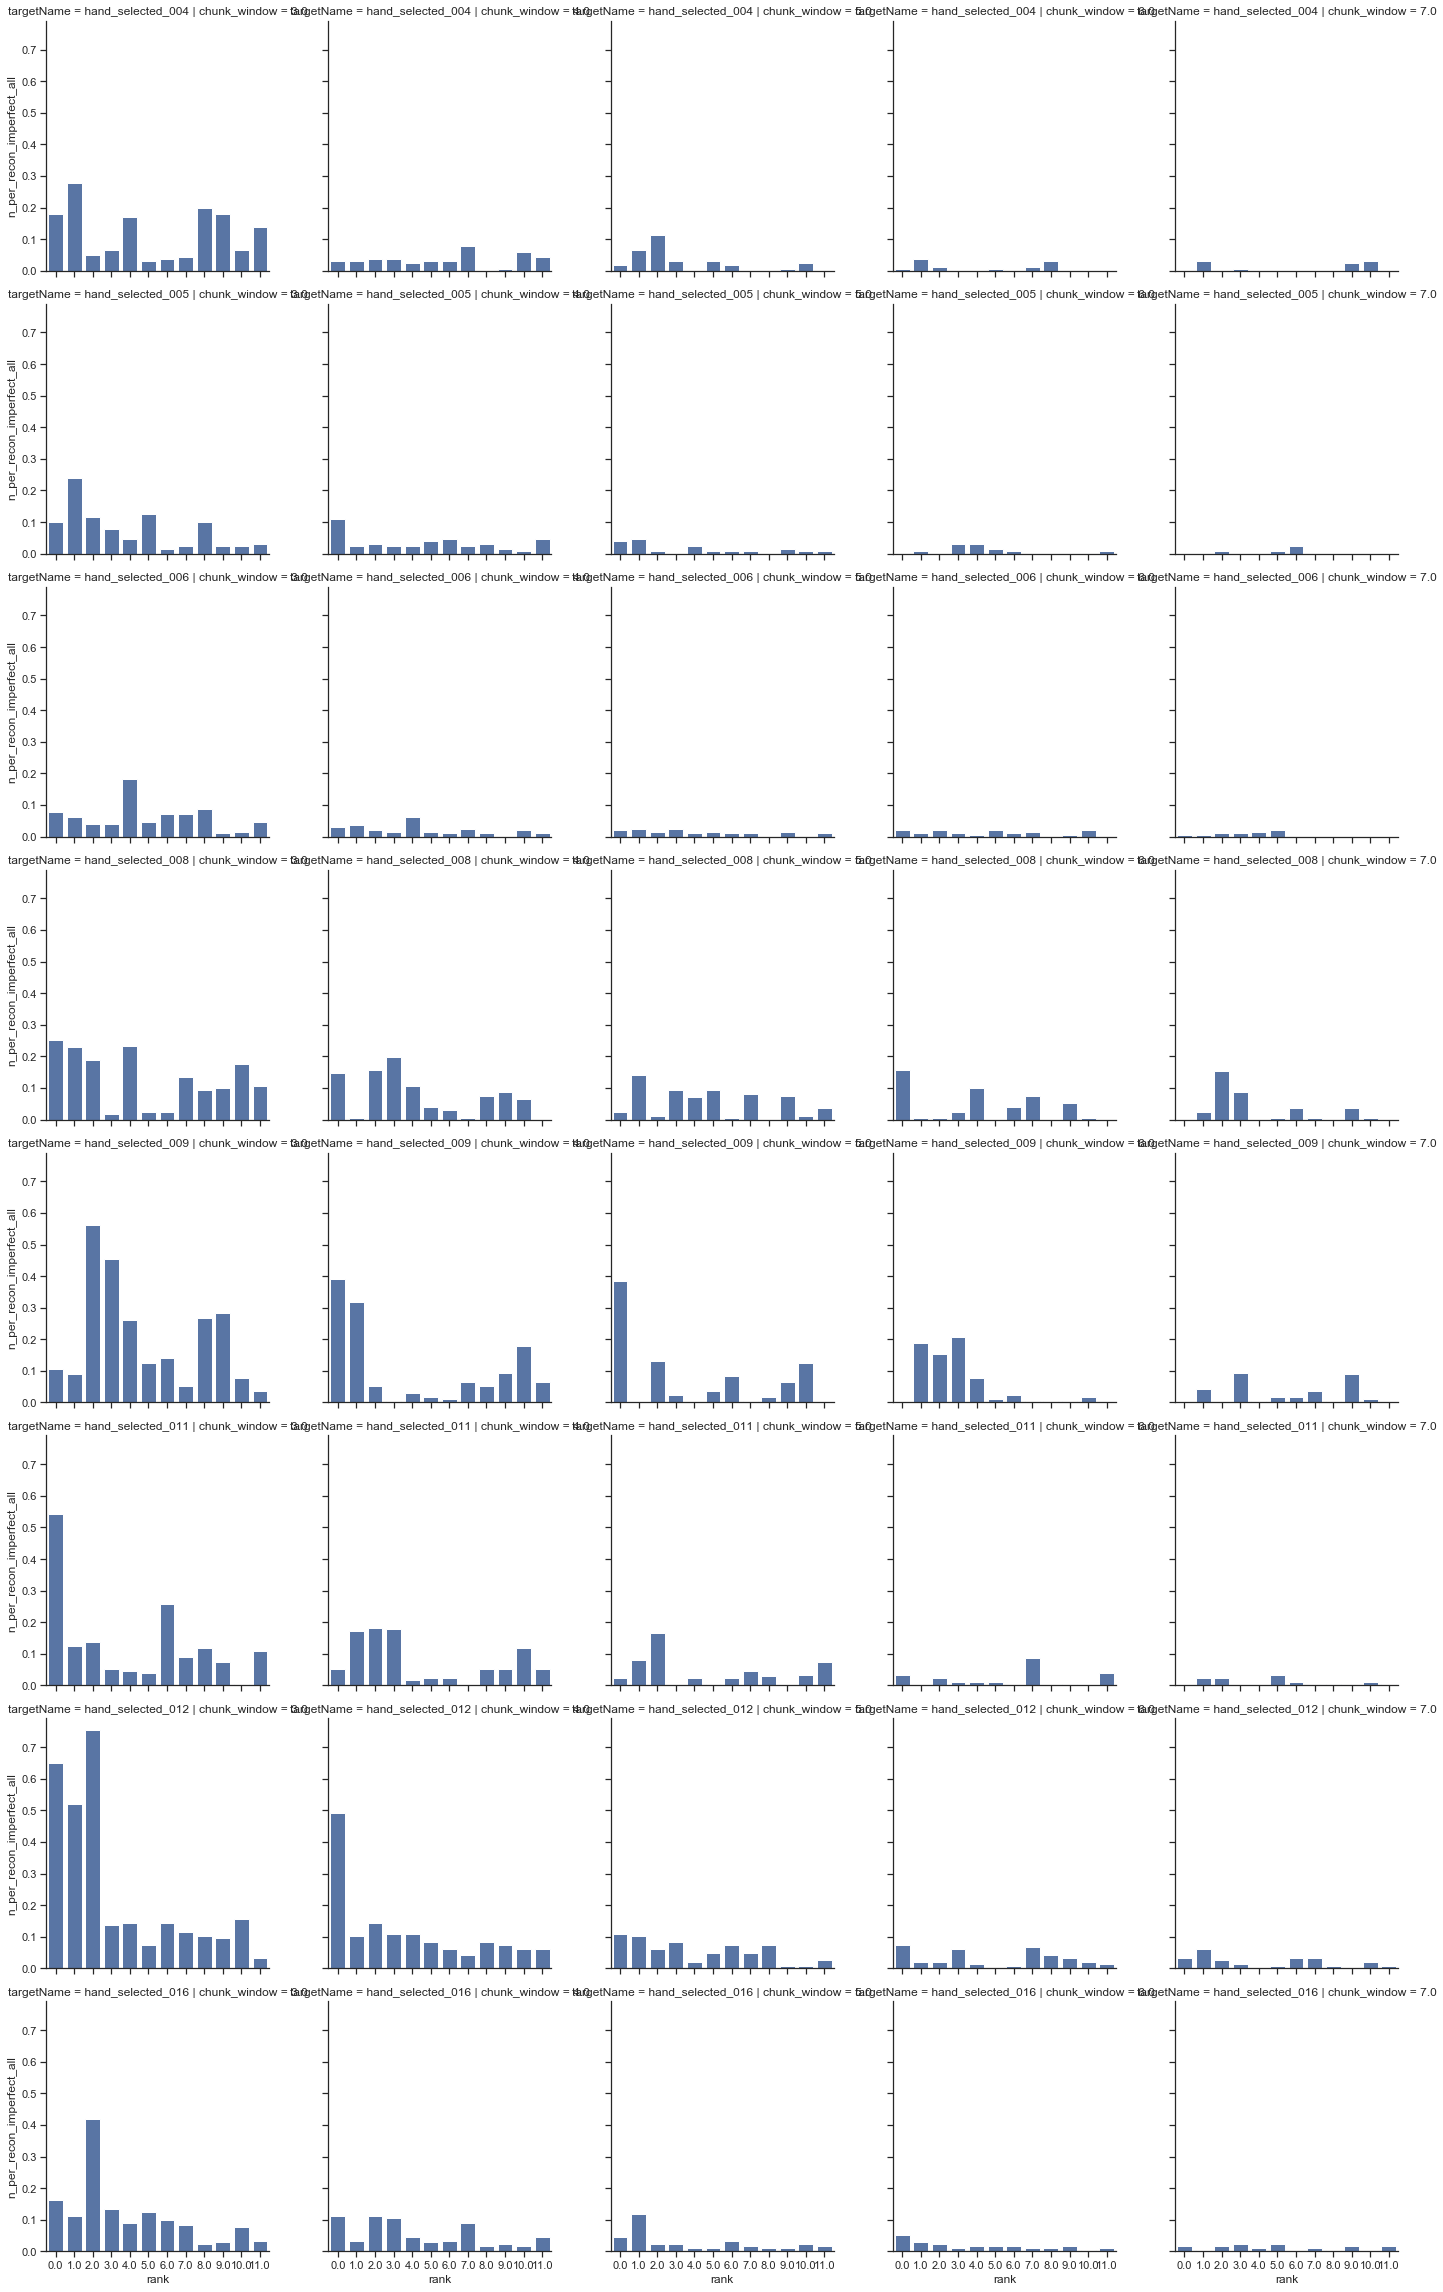

In [192]:
# How often were most popular chunks used in imperfect reconstructions?

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_top_chunks, col="chunk_window", row="targetName", height=4)
g.map(sns.barplot, "rank", "n_per_recon_imperfect_all");
# g.map(sns.pointplot, "rank","num_imperfect_post", color='orange');

<Figure size 720x432 with 0 Axes>

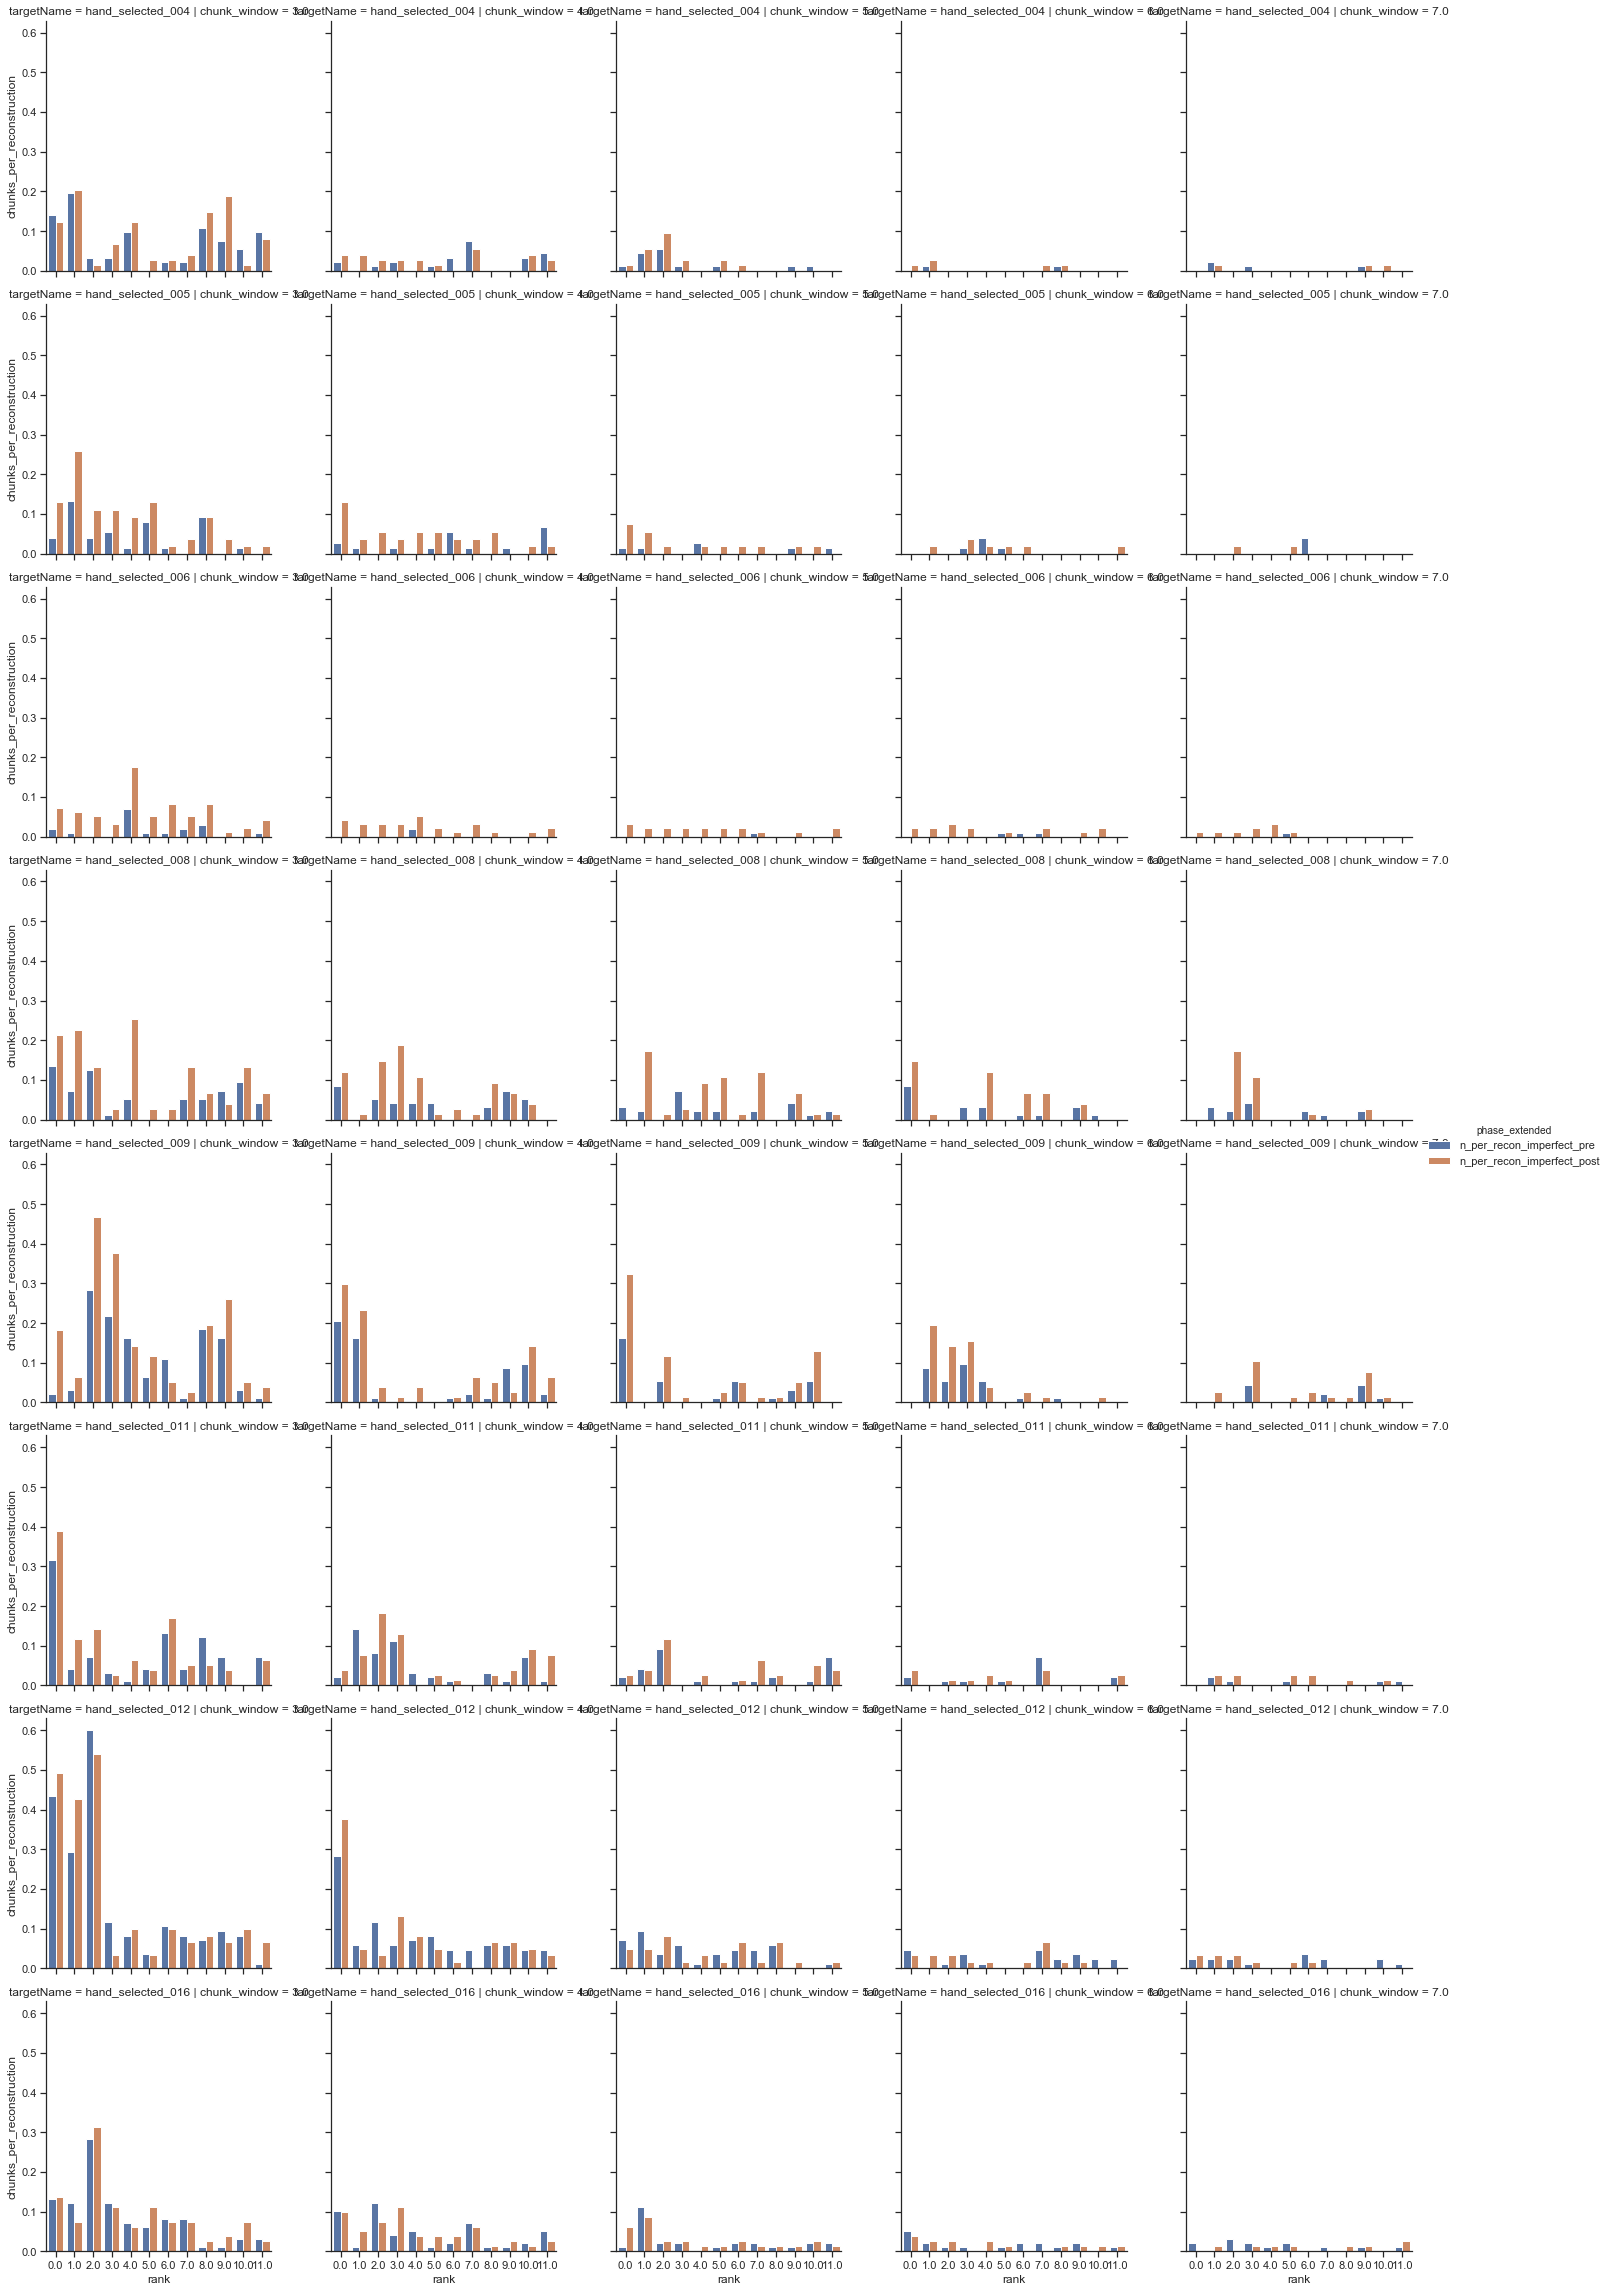

In [193]:
# How often were most popular chunks used in imperfect reconstructions, by phase?

df_top_chunks_pivot = df_top_chunks.melt(id_vars=['chunk_window',
                                                    'targetName',
                                                    'rank',
                                                  #'imperfect_count',
                                                    ],
                                           value_vars=['n_per_recon_imperfect_pre', 'n_per_recon_imperfect_post'],
                                           var_name='phase_extended', value_name='chunks_per_reconstruction')

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})

sns.catplot(data=df_top_chunks_pivot, 
            x='rank', 
            y='chunks_per_reconstruction', 
            col="chunk_window", 
            row="targetName", 
            hue="phase_extended", 
            height=4, 
            kind='bar', 
            hue_order=['n_per_recon_imperfect_pre', 'n_per_recon_imperfect_post'])

<Figure size 720x432 with 0 Axes>

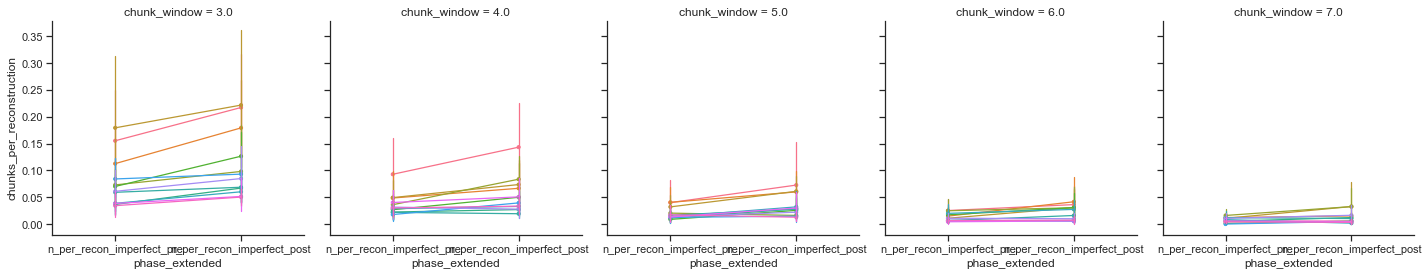

In [194]:
# How often were most popular chunks used in imperfect reconstructions, by phase?
# Here, each line is a chunk identified in from all perfect reconstructions (of a tower).
# They seem to be built more often in post.

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_top_chunks_pivot, col="chunk_window", col_wrap=5, height=4, hue='rank')
g.map(sns.pointplot, "phase_extended","chunks_per_reconstruction", order=['n_per_recon_imperfect_pre','n_per_recon_imperfect_post']);

<Figure size 1008x720 with 0 Axes>

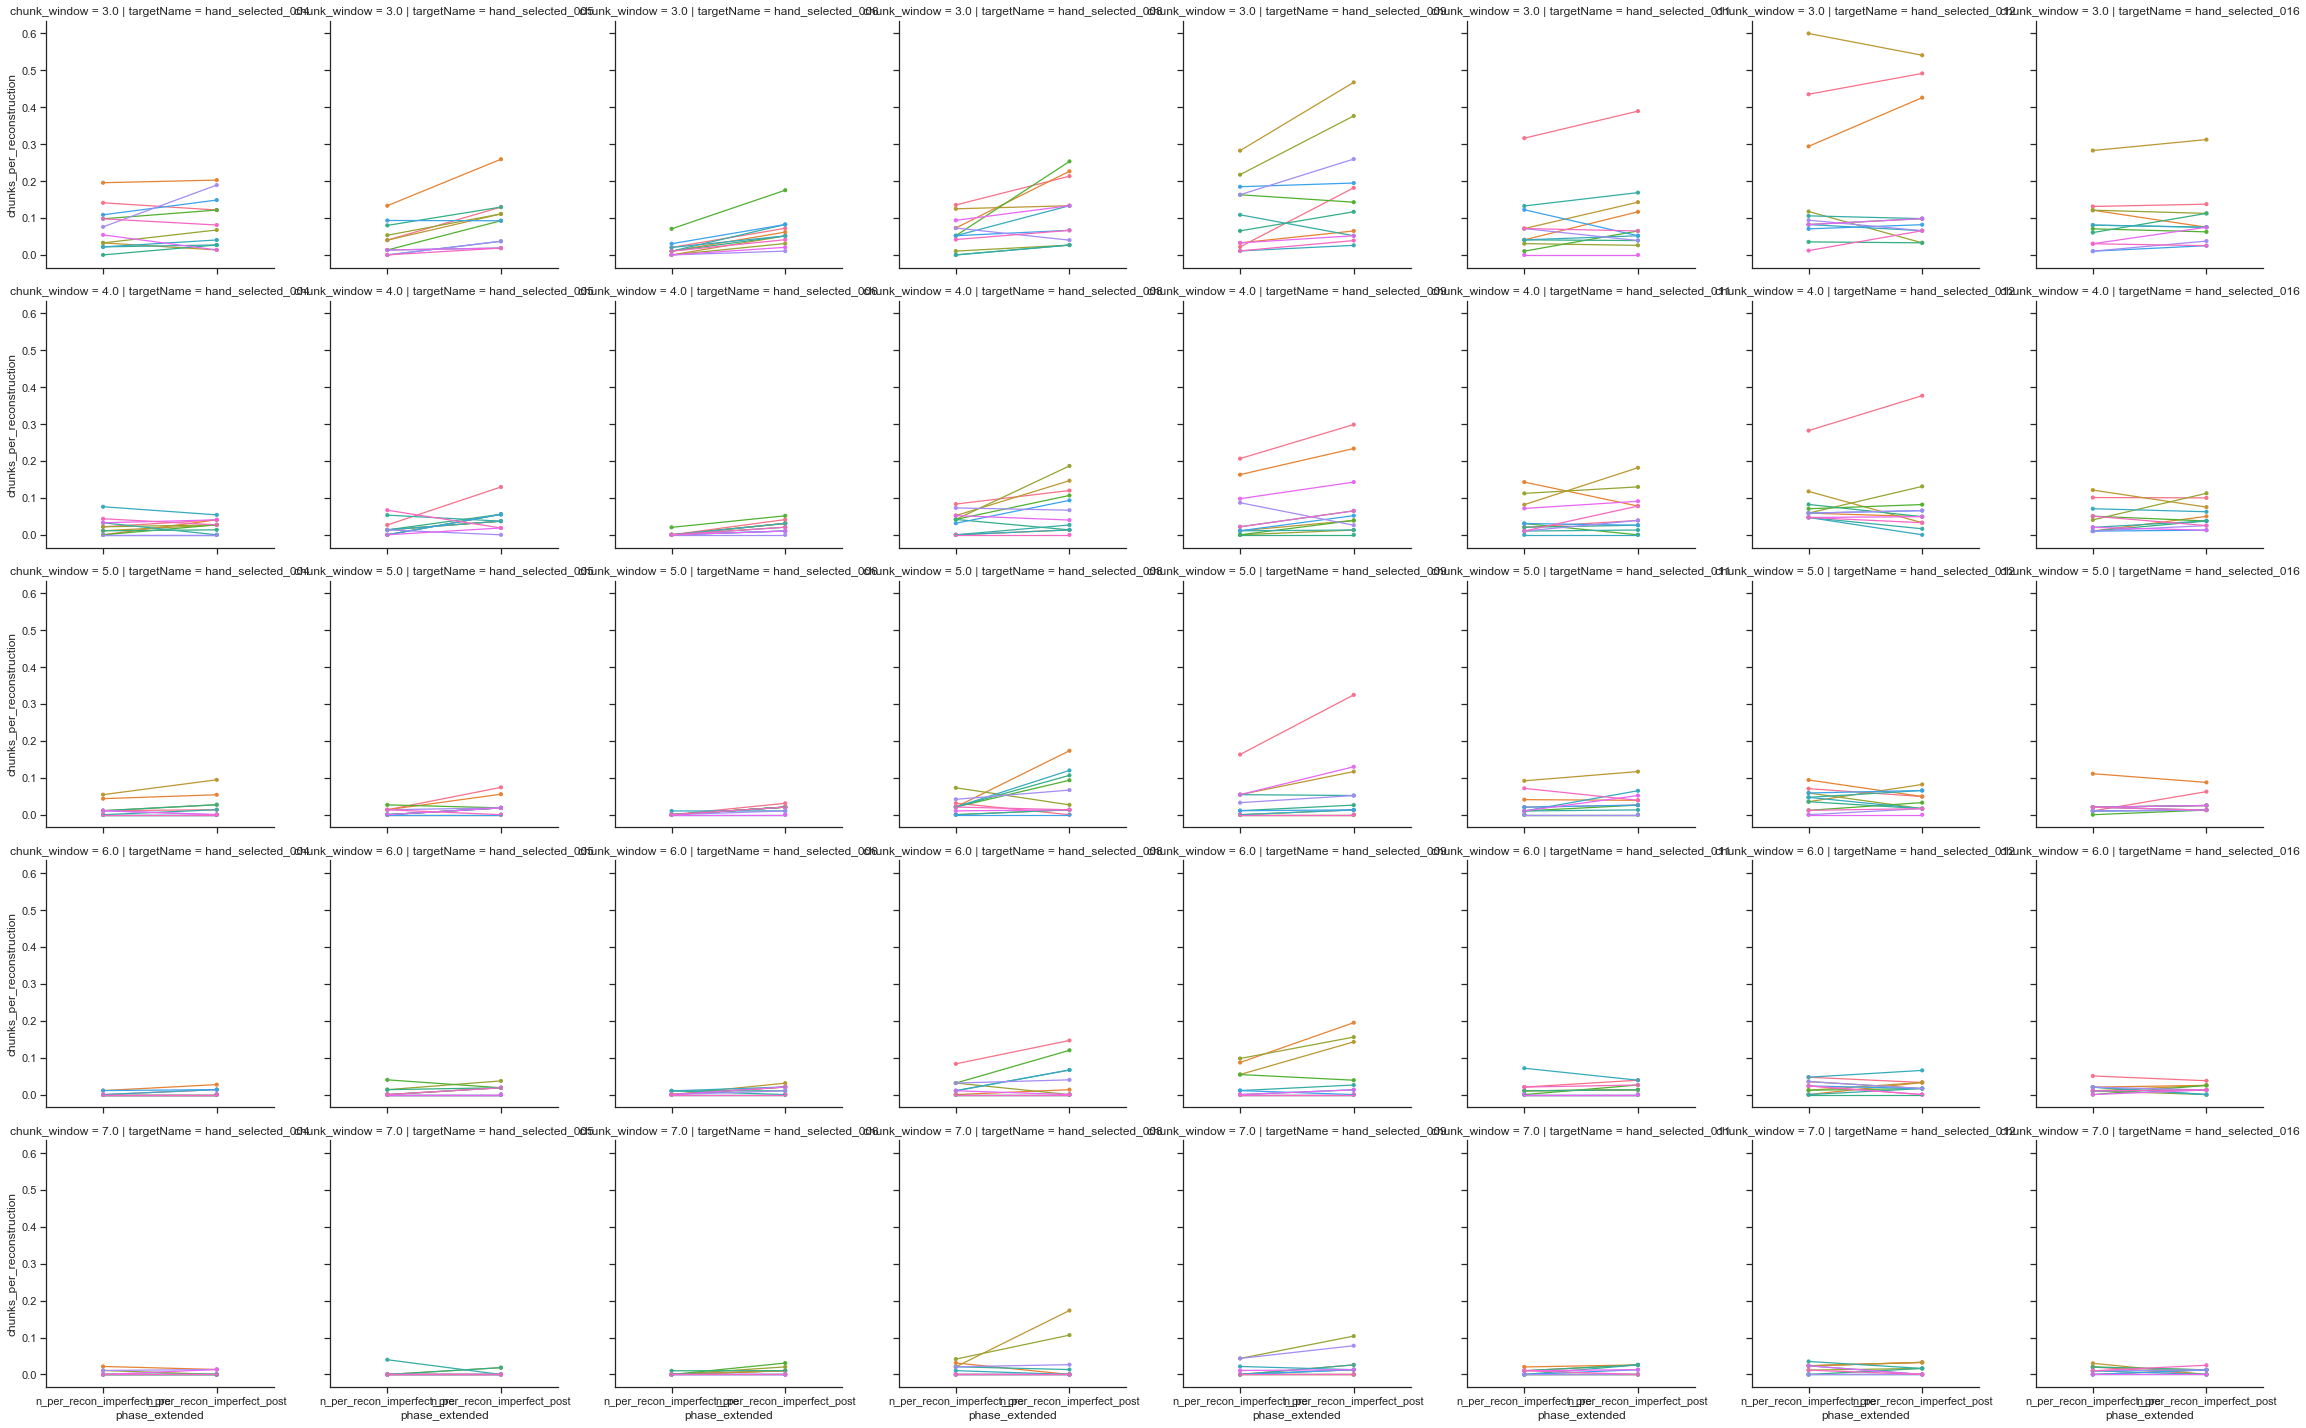

In [195]:
# How often were most popular chunks used in imperfect reconstructions, by phase?
# Here, each line is a chunk identified in from all perfect reconstructions (of a tower).
# They seem to be built more often in post.

fig = plt.figure(figsize=(14,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_top_chunks_pivot, col="targetName", row="chunk_window", hue='rank', height=4, col_order=targets)
g.map(sns.pointplot, "phase_extended", "chunks_per_reconstruction", order=['n_per_recon_imperfect_pre','n_per_recon_imperfect_post'])



In [ ]:
df_chunks = compute_all_chunks(window_sizes)

## Old analysis using perfect reconstructions

#### Identify most frequently built chunks from *perfect reconstructions only*

In [189]:
top_chunks_perfect = find_popular_chunks(dfic[dfic.perfectScore],
                                         window_sizes = window_sizes,
                                         n_chunks=n_top_chunks)

#### For each popular chunk in perfect reconstructions, find all imperfect reconstructions containing that chunk and summarize info in a new dataframe 

In [21]:
# Iterate over the 10 most popular chunks in all perfect reconstructions.
# Searches for each of these chunks in all of the imperfect reconstructions
# Calculate proportion of imperfect reconstructions (of that particular structure) that contain that chunk

df_top_chunks = pd.DataFrame()

df_top_chunks_recons = pd.DataFrame()

for chunk_window in window_sizes:
    
    for target in targets:
        
        n_imp_recons_pre = df_chunks[(df_chunks.phase_extended=='pre') & (df_chunks.perfectScore==False) & (df_chunks.targetName==target)].shape[0]
        n_imp_recons_post = df_chunks[(df_chunks.phase_extended=='post') & (df_chunks.perfectScore==False) & (df_chunks.targetName==target)].shape[0]

        for rank in range(n_top_chunks):

            # get the chunk
            chunk_item = list(top_chunks_perfect[chunk_window][target]['top_k_diff'])[rank]
            chunk = chunk_item[0] # [0] gets the chunk, [1] gets the count
            imperfect_count = chunk_item[1]
            
            # grab only structures with that chunk
            subset_with_chunk = df_chunks[(~df_chunks.perfectScore) & 
                                          (df_chunks.targetName == target) & 
                                          (df_chunks[str(chunk_window)+'_chunks'].apply(lambda chunks: chunk in chunks))]

#             top_chunks[chunk_window][target]['num_imperfect'][rank] = subset_with_chunk.shape[0]
#             top_chunks[chunk_window][target]['mean_F1'][rank] = np.mean(subset_with_chunk.rawF1DiscreteScore)
            
            df_top_chunks = df_top_chunks.append({
                'targetName' : target,
                'chunk_window' : chunk_window,
                'n_imp_recons_pre' : n_imp_recons_pre,
                'n_imp_recons_post' : n_imp_recons_post,
                'rank' : rank,
                'chunk' : chunk,
                'imperfect_count': imperfect_count,
                'num_imperfect_all' : subset_with_chunk.shape[0],
                'num_imperfect_pre' : subset_with_chunk[subset_with_chunk.phase_extended=='pre'].shape[0],
                'num_imperfect_post' : subset_with_chunk[subset_with_chunk.phase_extended=='post'].shape[0],
                'n_per_recon_imperfect_all':  subset_with_chunk.shape[0]/(n_imp_recons_pre+n_imp_recons_post),
                'n_per_recon_imperfect_pre' : subset_with_chunk[subset_with_chunk.phase_extended=='pre'].shape[0]/n_imp_recons_pre,
                'n_per_recon_imperfect_post' : subset_with_chunk[subset_with_chunk.phase_extended=='post'].shape[0]/n_imp_recons_post,
                'n_per_recon_imperfect_diff' : (subset_with_chunk[subset_with_chunk.phase_extended=='post'].shape[0]/n_imp_recons_post)-(subset_with_chunk[subset_with_chunk.phase_extended=='pre'].shape[0]/n_imp_recons_pre),
                'mean_F1' : np.mean(subset_with_chunk.rawF1DiscreteScore),
                'mean_F1_pre' : np.mean(subset_with_chunk[subset_with_chunk.phase_extended=='pre'].rawF1DiscreteScore),
                'mean_F1_post' : np.mean(subset_with_chunk[subset_with_chunk.phase_extended=='post'].rawF1DiscreteScore),
                'std_F1' : np.std(subset_with_chunk.rawF1DiscreteScore),
            }, ignore_index=True)
        

NameError: name 'top_chunks_perfect' is not defined

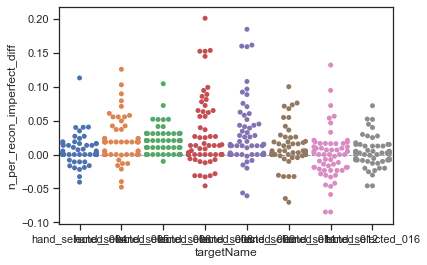

In [196]:
p = sns.swarmplot(y='n_per_recon_imperfect_diff', x='targetName', data=df_top_chunks, dodge=True)
ax = p.axes
ax.axhline(0, ls='--')

In [109]:
df_top_chunks[(df_top_chunks.n_per_recon_imperfect_diff < 0)].shape[0]

82

In [112]:
df_top_chunks[(df_top_chunks.n_per_recon_imperfect_diff == 0)].shape[0]

75

In [111]:
df_top_chunks[(df_top_chunks.n_per_recon_imperfect_diff > 0)].shape[0]

243

In [297]:
def draw_row_chunk(row, axs):
    axs[row.name].axis('off')
    chunk = row.chunk
    drawing.show_chunk([chunk], axs[row.name], target=row.targetName)

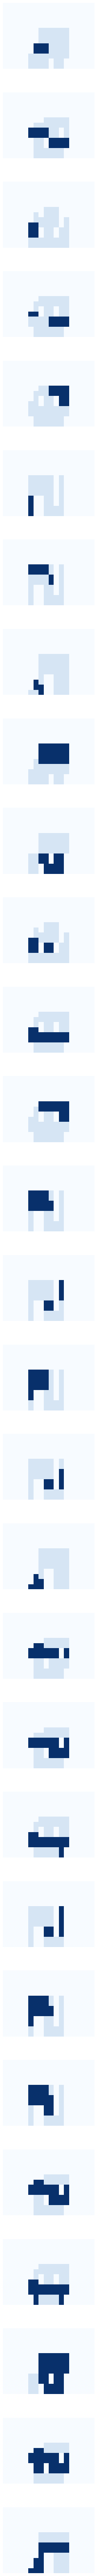

In [298]:
# show chunks built less over time 
df_negative_diffs = df_top_chunks[(df_top_chunks.n_per_recon_imperfect_diff < -0.03)].reset_index()
n_chunks = df_negative_diffs.shape[0]
fig, axs = plt.subplots(n_chunks, figsize=(4,n_chunks*4)) 

_ = df_negative_diffs.apply(lambda row: draw_row_chunk(row, axs), axis=1)


#### Mean accuracy of reconstructions containing popular chunks

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  import sys


<Figure size 720x432 with 0 Axes>

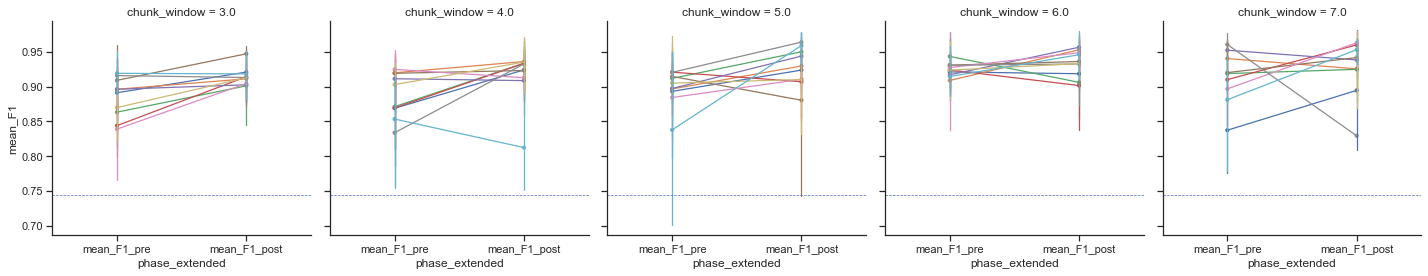

In [30]:
# Mean accuracy of reconstructions containing popular chunks, averaged across all targets

df_top_chunks_pivot = df_top_chunks.melt(id_vars=['chunk_window',
                                                    'targetName',
                                                    'rank'],
                                           value_vars=['mean_F1_pre', 'mean_F1_post'],
                                           var_name='phase_extended', value_name='mean_F1')

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_top_chunks_pivot, col="chunk_window", col_wrap=5, height=4, hue='rank')
g.map(sns.pointplot, "phase_extended","mean_F1", order=['mean_F1_pre', 'mean_F1_post']);

for ax in g.axes:
    mean_acc = np.mean(df_chunks[(~df_chunks.perfectScore)]['rawF1DiscreteScore'])
    ax.axhline(mean_acc, ls='--')

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  


<Figure size 720x432 with 0 Axes>

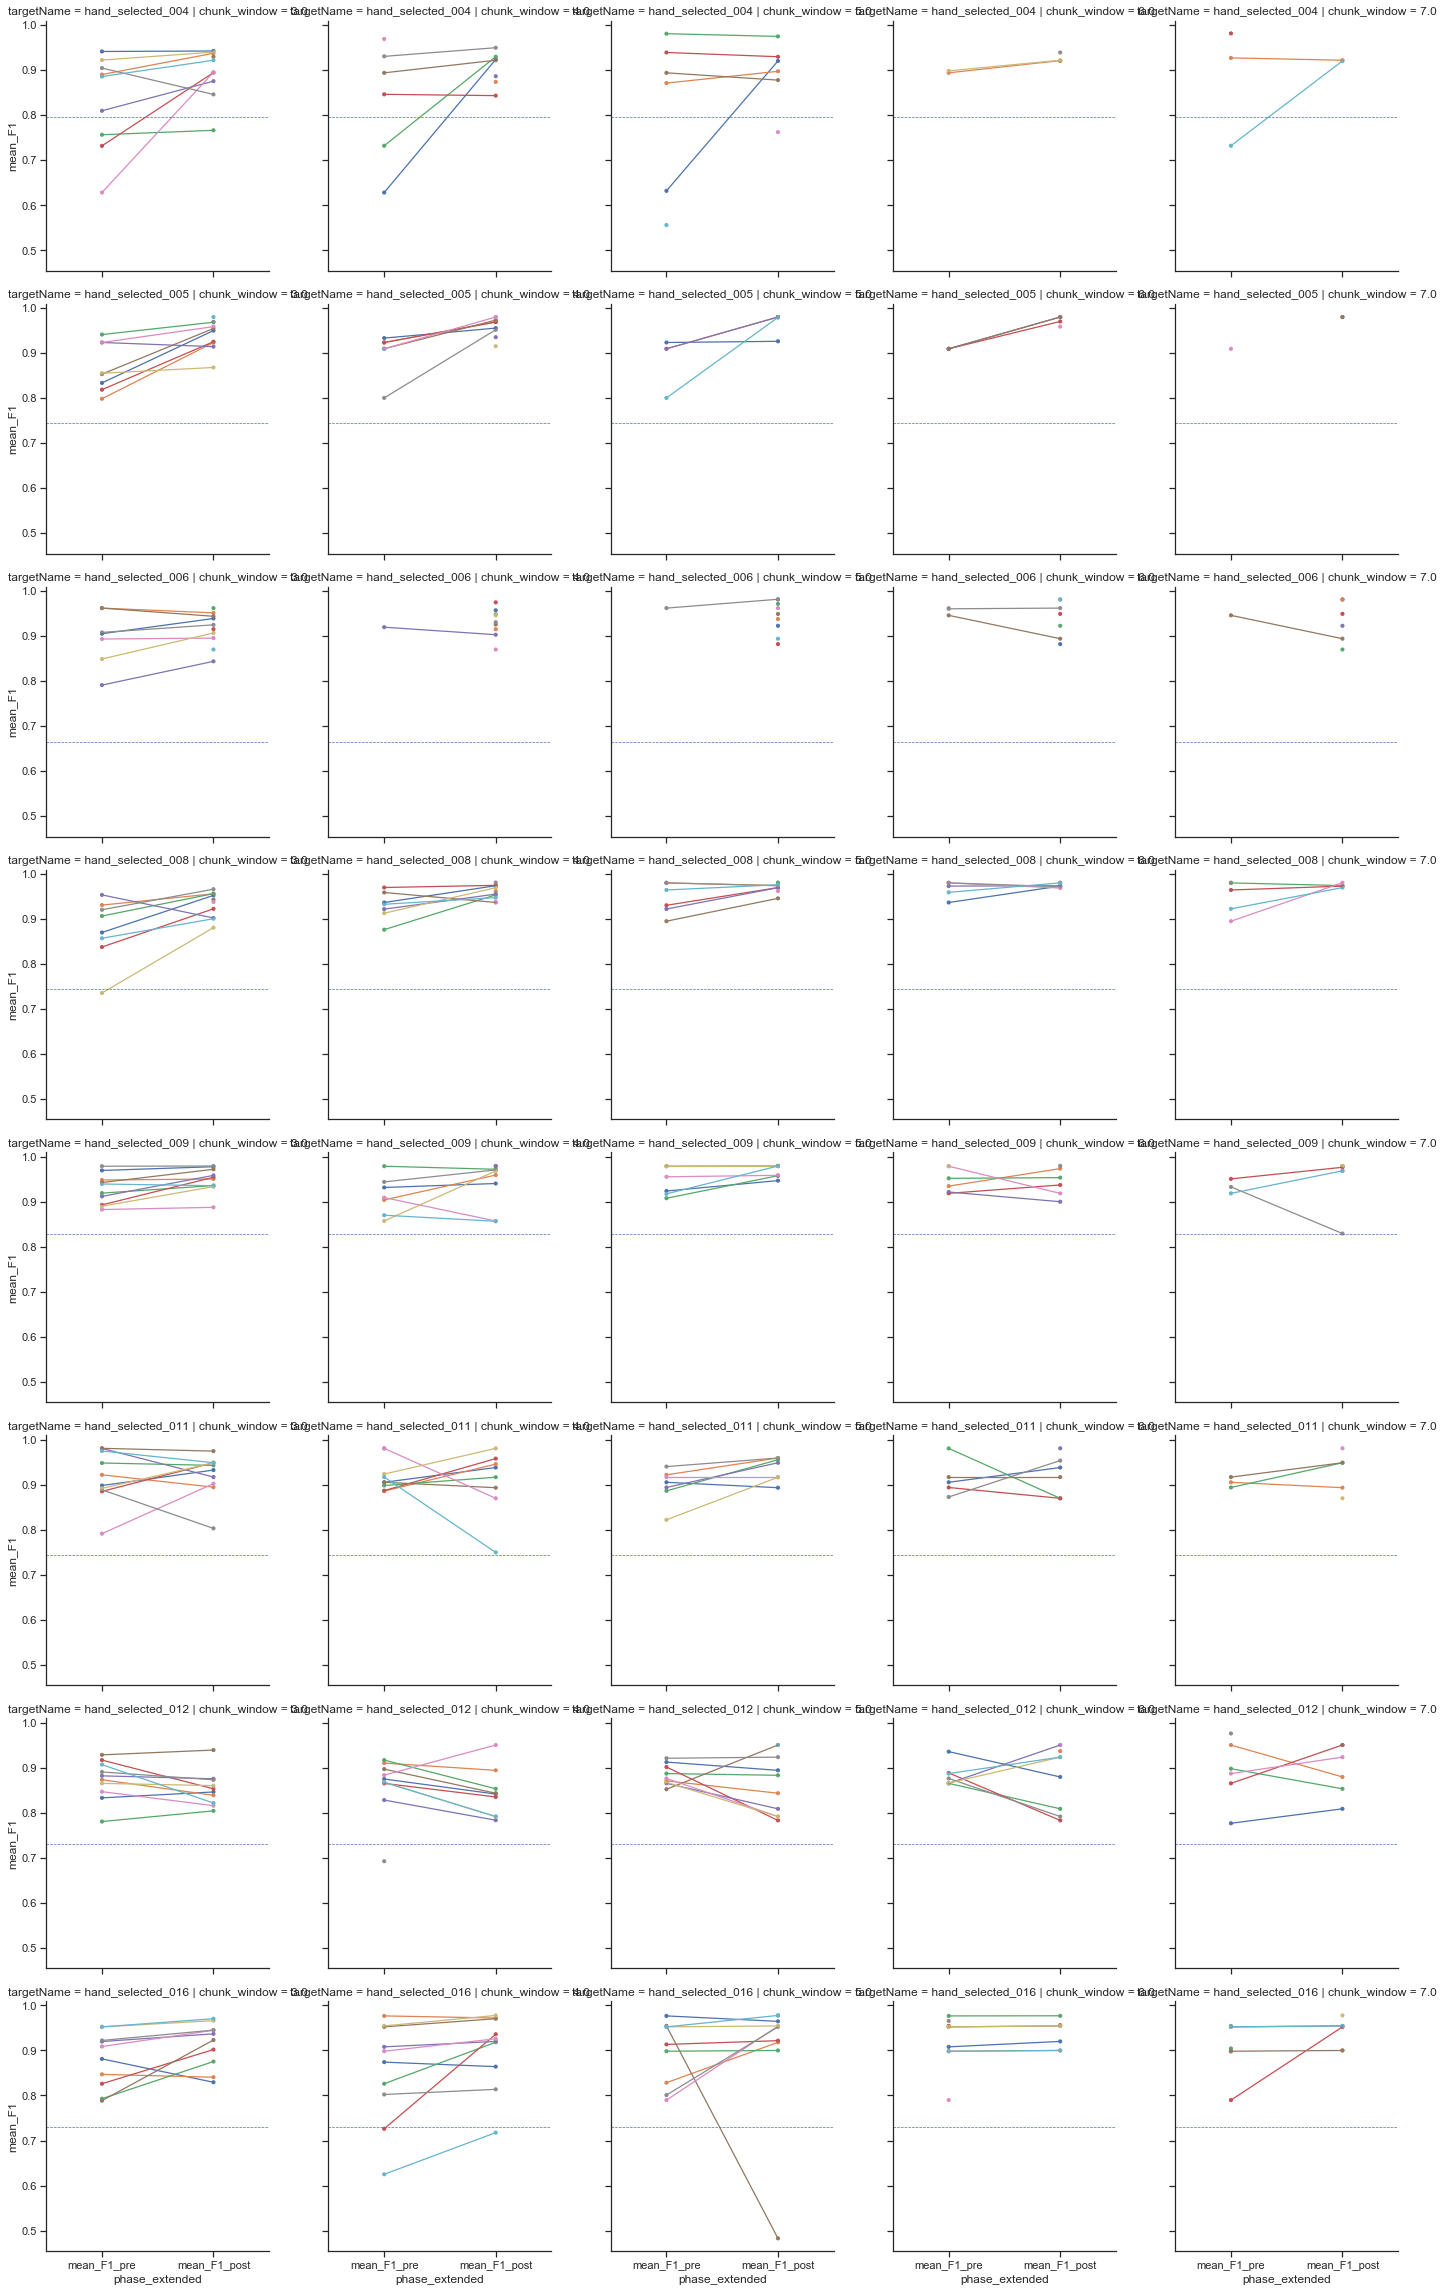

In [31]:
# Mean accuracy of reconstructions containing popular chunks, by structure
# Horizontal lines are mean accuracy of all imperfect reconstructions (those with AND without the chunk)

df_top_chunks_pivot = df_top_chunks.melt(id_vars=['chunk_window',
                                                    'targetName',
                                                    'rank'],
                                           value_vars=['mean_F1_pre', 'mean_F1_post'],
                                           var_name='phase_extended', value_name='mean_F1')

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})

g = sns.FacetGrid(df_top_chunks_pivot, col="chunk_window", row="targetName", height=4, hue='rank')
g.map(sns.pointplot, "phase_extended","mean_F1", order=['mean_F1_pre', 'mean_F1_post']);

for target_i, axes in enumerate(g.axes):
    for ax in axes:
        mean_acc = np.mean(df_chunks[(~df_chunks.perfectScore) & 
                          (df_chunks.targetName == targets[target_i])]['rawF1DiscreteScore'])
        ax.axhline(mean_acc, ls='--')